## XGBoost model

*   Model = *decision tree ensembles*, which consists of a set of classification and regression trees. Supervised learning.
*   How: decides on threshold per feature (below -> certain score, eg -2: above -> certain score, eg +1). Add scores of all 'leafs' (= 1 split/decision)
*   Difference with decision tree: not only decision values, but also gives scores to each leaf outcome (therefore, richer model)
*   Same as random forest, difference is that they are trained in a different way, ie with additive training: learn 1 new tree at a time, while keeping fixed what was learned. At every step compare: better performance? If not,keep simpler model.
https://xgboost.readthedocs.io/en/latest/tutorials/model.html

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
#% matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

def xgb_mape(ypred, dtest):
   labels = dtest.get_label()
   return('MAPE (%)', np.mean(np.abs((labels - ypred) / labels) * 100))
def wfv_mape(ypred, dtest):
   return('MAPE (%)', np.mean(np.abs((dtest - ypred) / dtest) * 100))

## All features

In [3]:
# import the data (all features) - data split in train/test data
X_train = pd.read_csv('train_X_all.csv'); X_test = pd.read_csv('test_X_all.csv')
y_train = pd.read_csv('train_y_all.csv'); y_test = pd.read_csv('test_y_all.csv')
print(['Size train set: ',len(X_train)]);
print(['Size test set: ',len(X_test)]);
X_train.head()

['Size train set: ', 294]
['Size test set: ', 56]


YearDayNum  NumO1  NumO2  NumO3  NumO4  NumR1  NumR2  NumR3  NumR4  NumSA1  \
0         282     64     70     95    134      4      9     14     22      80   
1         283     55     77    104    143      4      8     23     26      67   
2         284     59     92    102    140      4      6     14     22      89   
3         285     49     79     92    145      7      9     18     27      83   
4         288     44     75     94    123      7      9     11     21      62   

   ...  at_inbound  at_outbound  temp  wspd  COND_Snow  WTYPE_Fog  WTYPE_Ice  \
0  ...     1819716      1858207  20.8  29.3          0          0          0   
1  ...     1819716      1858207  24.2  27.3          0          0          0   
2  ...     1819716      1858207  17.2  20.4          0          0          0   
3  ...     1819716      1858207  14.7  34.8          0          0          0   
4  ...     1819716      1858207  13.8  38.4          0          0          0   

   WTYPE_Smoke_Or_Haze  dow_jones  weekly_mean_dj  
0                    0   26430.57      25605.5325  
1                    0   25598.74      25605.5325  
2                    0   25052.83      25605.5325  
3                    0   25339.99      25605.5325  
4                    0   25250.55      25515.8880  

[5 rows x 50 columns]

In [ ]:
# Optimize params with GridSearchCV
y_interest = 'CFuture4'
param_grid = {
     'eta': [0.001,0.01,0.1,0.2,0.3],
    'colsample_bytree': [0, 0.2, 0.4, 0.6,0.8,1],
    'n_estimators': [10,20,40,60,80,100,130],
    'max_depth': [2,3,4,5],
    'min_samples_leaf': [10,20,40,80],
    'objective': ['reg:squarederror'],
    'eval_metric':['rmse'], #'reg:linear'
    'gamma':[0.1,0.3,0.5] # regularization
    # additional params
    #'min_samples_split': [] # min samples at node to considered for another split
    #'max_featues': optimal is sqrt of num features up to 40%
}
xgb_model = xgb.XGBRegressor(); #XGBClassifier()
xgb1 = GridSearchCV(estimator=xgb_model, param_grid=param_grid,cv=5,scoring='neg_mean_squared_error',verbose=1);
#X_train = df_train[['at_inbound','at_outbound']]; y_train = df_train['CFuture1']

dtrain = xgb.DMatrix(X_train, label=y_train[y_interest]); # train data + y
xgbfit = xgb1.fit(X_train,y_train[y_interest]);

print(xgb1.best_params_);
print(xgb1.best_score_);
# Print the best parameters and lowest RMSE
print("Best parameters found: ", xgb1.best_params_);
print("Lowest RMSE found: ", np.sqrt(np.abs(xgb1.best_score_)));

#xgb.plot_importance(xgbfit) #  counting the number of times each feature is split on across all boosting rounds (trees) in the model,
#and then visualizing the result as a bar graph, with the features ordered according to how many times they appear.
#xgb.plot_tree(xgbfit, num_trees=2)

Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 50400 out of 50400 | elapsed: 30.0min finished


{'colsample_bytree': 0.2, 'eta': 0.001, 'eval_metric': 'rmse', 'gamma': 0.1, 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 40, 'objective': 'reg:squarederror'}
-1379756.6609563725
Best parameters found:  {'colsample_bytree': 0.2, 'eta': 0.001, 'eval_metric': 'rmse', 'gamma': 0.1, 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 40, 'objective': 'reg:squarederror'}
Lowest RMSE found:  1174.6304359058522


y predicted:  [101.793335 111.27334  111.27334  111.27334  111.27334  111.27334
 111.27334  111.27334  111.27334 ]
real y:               1     2     3     4     5     6     7     8     9
CFuture1  1086  1274  1199  1171  1218  1210  1240  1247  1188
CFuture2  2325  2417  2517  2435  2429  2407  2405  2412  2274
CFuture3  4438  4897  4549  4844  4906  4633  4692  4548  4731
CFuture4  9272  9009  9230  9454  9084  8777  9094  9204  9068

RMSE"  1006.5948402583613
('MAPE (%)', 90.24927)


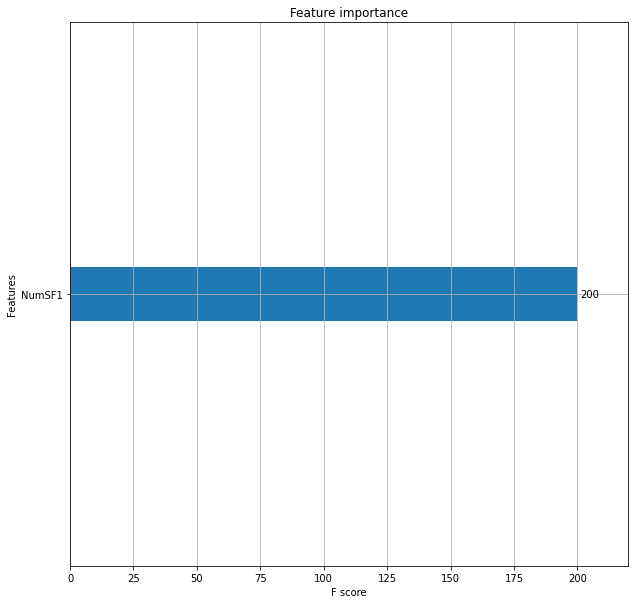

In [ ]:
# QUICK MODEL - filled in params from GridSearchCV optimization
y_interest = 'CFuture1'
dtrain = xgb.DMatrix(X_train, label=y_train[y_interest]) # train data + y
dtest = xgb.DMatrix(X_test, label=y_test[y_interest]) # test data + y
params = {
    'booster':'gbtree',
    'objective': 'reg:squarederror', #'reg:linear' # not so much different output..
    'eval_metric':'rmse',
    'eta': 0.001,#0.001, # 0.001, 0.01, 0.1
    'max_depth': 2,
    'colsample_bytree': 1,
    'n_estimators': 80,
    'min_samples_leaf': 10,
    'gamma':0.1
    }

# Train
bst = xgb.train(params, dtrain, num_boost_round=100) #number of rounds -> the higher, the higher the 'feature importance'
# early_stopping_rounds=10
#cv_results = xgb.cv(dtrain=dtrain,params=params,nfold=3,metrics='rmse',num_boost_round=50,early_stopping_rounds=10,as_pandas=True)

# Predict
ypred = bst.predict(dtest)
print('y predicted: ',ypred[1:10])
print('real y: ',y_test[1:10].T)
print('\nRMSE" ', np.sqrt(mean_squared_error(y_test[y_interest],ypred)));
print(xgb_mape(ypred,dtest))

fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(bst, ax=ax) #  counting the number of times each feature is split on across all boosting rounds (trees) in the model,
#and then visualizing the result as a bar graph, with the features ordered according to how many times they appear.
# Most important features seem: YearDayNum, all Num vars, temp, wspd, Dow Jones

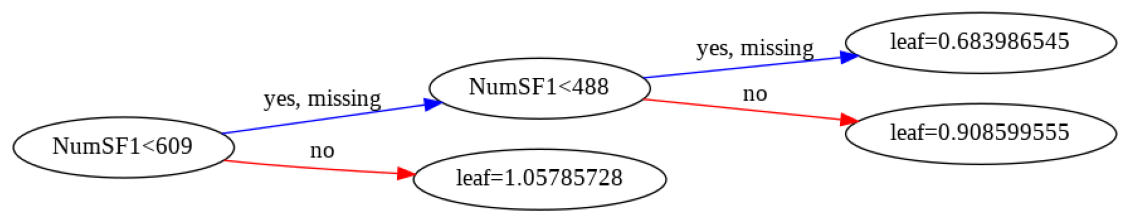

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(bst, ax=ax,rankdir="LR",num_trees=99) # needs graphviz. num_trees -> nth tree. 99= last one (num_boost_tree)

y predicted:  [ 963.93677 1178.007   1135.8368  1133.9858   983.16986 1177.8805
 1185.1262  1160.0865  1166.8876 ]
real y:               1     2     3     4     5     6     7     8     9
CFuture1  1086  1274  1199  1171  1218  1210  1240  1247  1188
CFuture2  2325  2417  2517  2435  2429  2407  2405  2412  2274
CFuture3  4438  4897  4549  4844  4906  4633  4692  4548  4731
CFuture4  9272  9009  9230  9454  9084  8777  9094  9204  9068

RMSE"  80.70405796776477
[ 995. 1086. 1274. 1199. 1171. 1218. 1210. 1240. 1247. 1188. 1198. 1162.
 1138. 1081. 1160. 1073. 1177. 1110. 1187. 1151. 1179. 1211. 1229. 1243.
 1290. 1272. 1172. 1200. 1199.  854.  875.  775.  814.  841. 1178. 1233.
 1208. 1167. 1231. 1180. 1219. 1181. 1216. 1222. 1215. 1216. 1054.  869.
  847.  771.  815.  814.  818.  917.  950.  963.]
('MAPE (%)', 6.063228)


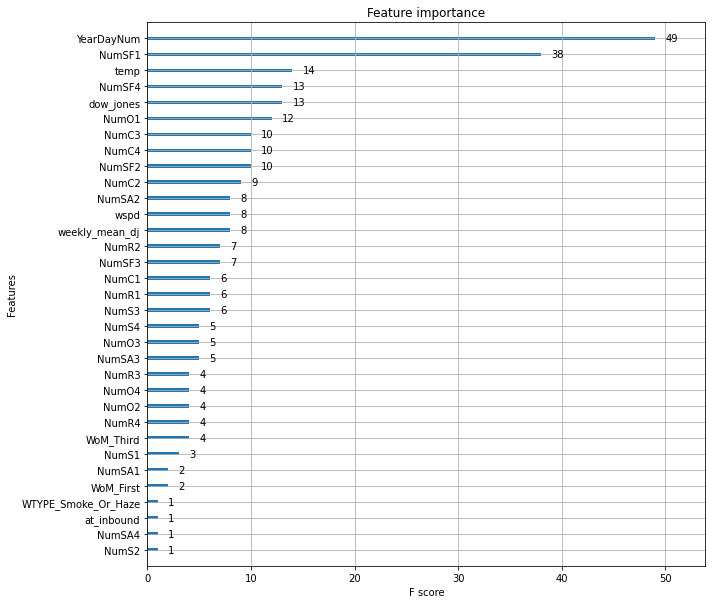

In [ ]:
# QUICK MODEL - random params -> performs better?!
params = {
    'booster':'gbtree',
    'objective': 'reg:squarederror', #'reg:linear' # not so much different output..
    'eta': 0.2, #0.001, # 0.001, 0.01, 0.1 -> this is the cause of the difference! If lower, few features used
    'max_depth': 3, #5
    'colsample_bytree': 1,
    'n_estimators': 60
    }
# Train
bst = xgb.train(params, dtrain, num_boost_round=50) #number of rounds -> the higher, the higher the 'feature importance'
# Predict
ypred = bst.predict(dtest)
print('y predicted: ',ypred[1:10])
print('real y: ',y_test[1:10].T)
print('\nRMSE" ', np.sqrt(mean_squared_error(y_test[y_interest],ypred)));
print(xgb_mape(ypred,dtest))
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(bst, ax=ax)

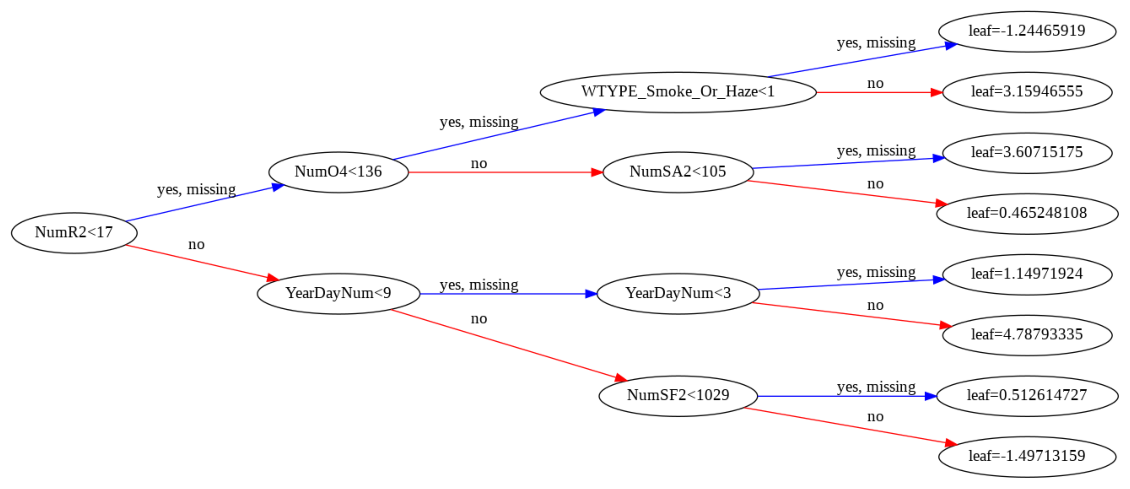

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(bst, ax=ax,rankdir="LR",num_trees=49) # needs graphviz. num_trees -> nth tree. 49= last one ()

# Walk forward validation

In [8]:
# Walk Forward Validation. From: https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=False):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols = list()
	# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
	# put it all together
    agg = pd.concat(cols, axis=1)
    if dropnan:
      agg.dropna(inplace=True)
    return agg.values

# walk-forward validation for univariate data
def walk_forward_validation(X_train,y_train, X_test,y_test,params):
  train=np.concatenate((X_train,np.reshape(np.asarray(y_train),(-1,1))),axis=1)
  test=np.concatenate((X_test,np.reshape(np.asarray(y_test),(-1,1))),axis=1)
  predictions = list()
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  for i in range(len(test)):
		# split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
    yhat, model = xgboost_forecast(history, testX,params)
		# store forecast in list of predictions
    predictions.append(yhat)
		# add actual observation to history for the next loop
    history.append(test[i])
		# summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
  print(wfv_mape(predictions,test[:, -1]))
  mape = np.mean(np.abs((test[:, -1] - predictions) / test[:, -1]) * 100)
  rmse = np.sqrt(mean_squared_error(test[:, -1],predictions));
  return rmse, mape, test[:, -1], predictions, model

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX,params):
	# transform list into array
  train = np.asarray(train)
	# split into input and output columns
  trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
  model = xgb.XGBRegressor(params=params, objective='reg:squarederror', n_estimators=1000)
  model.fit(trainX, trainy)
	# make a one-step prediction
  yhat = model.predict([testX])
  return yhat[0], model

>expected=995.0, predicted=988.1
>expected=1086.0, predicted=941.0
>expected=1274.0, predicted=1133.5
>expected=1199.0, predicted=1178.2
>expected=1171.0, predicted=1175.4
>expected=1218.0, predicted=1072.7
>expected=1210.0, predicted=1162.3
>expected=1240.0, predicted=1185.8
>expected=1247.0, predicted=1171.3
>expected=1188.0, predicted=1204.5
>expected=1198.0, predicted=1120.5
>expected=1162.0, predicted=1211.8
>expected=1138.0, predicted=1117.1
>expected=1081.0, predicted=1206.2
>expected=1160.0, predicted=1175.9
>expected=1073.0, predicted=1084.3
>expected=1177.0, predicted=1155.5
>expected=1110.0, predicted=1231.5
>expected=1187.0, predicted=1195.5
>expected=1151.0, predicted=1185.2
>expected=1179.0, predicted=1201.1
>expected=1211.0, predicted=1185.9
>expected=1229.0, predicted=1203.4
>expected=1243.0, predicted=1209.2
>expected=1290.0, predicted=1197.9
>expected=1272.0, predicted=1206.1
>expected=1172.0, predicted=1222.9
>expected=1200.0, predicted=1226.4
>expected=1199.0, predi

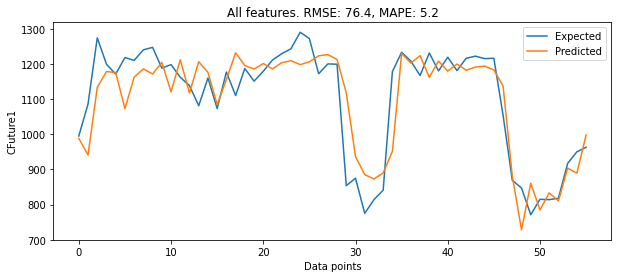

In [ ]:
# transform the time series data into supervised learning
Xtrain_data = series_to_supervised(X_train, n_in=6) # use consecutive days
Xtest_data = series_to_supervised(X_test, n_in=6)

# evaluate
y_pred = 'CFuture1'
#future1:
params={'colsample_bytree': 1, 'eta': 0.2, 'eval_metric': 'rmse', 'gamma': 0.4, 'max_depth': 4, 'min_samples_leaf': 10, 'n_estimators': 80, 'objective': 'reg:squarederror'}
rmse, mape, y, yhat, model = walk_forward_validation(Xtrain_data, y_train[y_pred], Xtest_data, y_test[y_pred],params)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
print(['Used params (optimized by GridSearchCV): ', params])
# plot expected vs preducted
fig = plt.figure(figsize=(10,4))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.title(f'All features. RMSE: {round(rmse,1)}, MAPE: {round(mape,1)}')
plt.ylabel('CFuture1'); plt.xlabel('Data points')
fig.savefig('CFuture1_all_wfv6_eta0_2_maxdepth4_gamma0_4.pdf')
fig.savefig('CFuture1_all_wfv6_eta0_2_maxdepth4_gamma0_4.jpg')

>expected=2340.0, predicted=2127.5
>expected=2325.0, predicted=2177.3
>expected=2417.0, predicted=2385.5
>expected=2517.0, predicted=2380.7
>expected=2435.0, predicted=2453.7
>expected=2429.0, predicted=2317.7
>expected=2407.0, predicted=2186.6
>expected=2405.0, predicted=2356.7
>expected=2412.0, predicted=2463.1
>expected=2274.0, predicted=2408.0
>expected=2281.0, predicted=2355.9
>expected=2241.0, predicted=2375.6
>expected=2287.0, predicted=2255.1
>expected=2349.0, predicted=2315.4
>expected=2326.0, predicted=2374.9
>expected=2377.0, predicted=2342.2
>expected=2440.0, predicted=2370.2
>expected=2392.0, predicted=2440.7
>expected=2455.0, predicted=2324.8
>expected=2399.0, predicted=2316.3
>expected=2420.0, predicted=2307.8
>expected=2435.0, predicted=2403.0
>expected=2385.0, predicted=2413.6
>expected=2314.0, predicted=2431.2
>expected=2168.0, predicted=2224.8
>expected=2134.0, predicted=2217.0
>expected=2010.0, predicted=2323.8
>expected=1979.0, predicted=2223.2
>expected=2069.0, pr

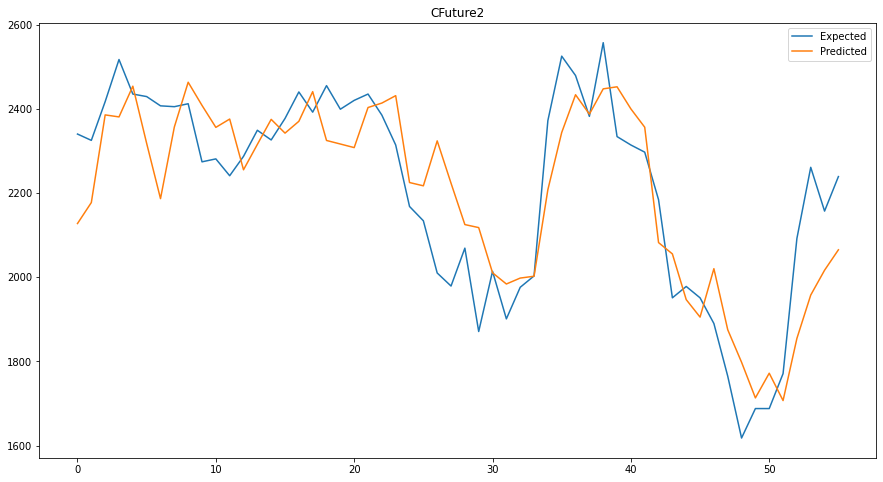

In [ ]:
y_pred = 'CFuture2'
# params optimized for CFuture2 using GridSearchCV
params={'colsample_bytree': 1, 'eta': 0.001, 'eval_metric': 'rmse', 'gamma': 0.1, 'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 130, 'objective': 'reg:squarederror'}
rmse2, mape2, y, yhat = walk_forward_validation(Xtrain_data, y_train[y_pred], Xtest_data, y_test[y_pred],params)
print('RMSE: %.3f' % rmse2)
print('MAPE: %.3f' % mape2)
print(['Used params (optimized by GridSearchCV): ', params])
# plot expected vs predicted
plt.figure(figsize=(15,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.title(y_pred)
plt.show()

>expected=4610.0, predicted=3983.0
>expected=4438.0, predicted=4329.9
>expected=4897.0, predicted=4409.4
>expected=4549.0, predicted=4506.1
>expected=4844.0, predicted=4589.9
>expected=4906.0, predicted=4632.1
>expected=4633.0, predicted=4556.8
>expected=4692.0, predicted=4633.1
>expected=4548.0, predicted=4540.6
>expected=4731.0, predicted=4487.0
>expected=4629.0, predicted=4517.2
>expected=4582.0, predicted=4523.7
>expected=4767.0, predicted=4612.2
>expected=4577.0, predicted=4619.9
>expected=4537.0, predicted=4524.6
>expected=4425.0, predicted=4404.0
>expected=4454.0, predicted=4371.9
>expected=4479.0, predicted=4574.6
>expected=4557.0, predicted=4560.8
>expected=4397.0, predicted=4438.4
>expected=4388.0, predicted=4462.5
>expected=4255.0, predicted=4584.8
>expected=4416.0, predicted=4406.8
>expected=4374.0, predicted=4461.7
>expected=4563.0, predicted=4452.6
>expected=4582.0, predicted=4412.7
>expected=4415.0, predicted=4454.1
>expected=4579.0, predicted=4531.5
>expected=4358.0, pr

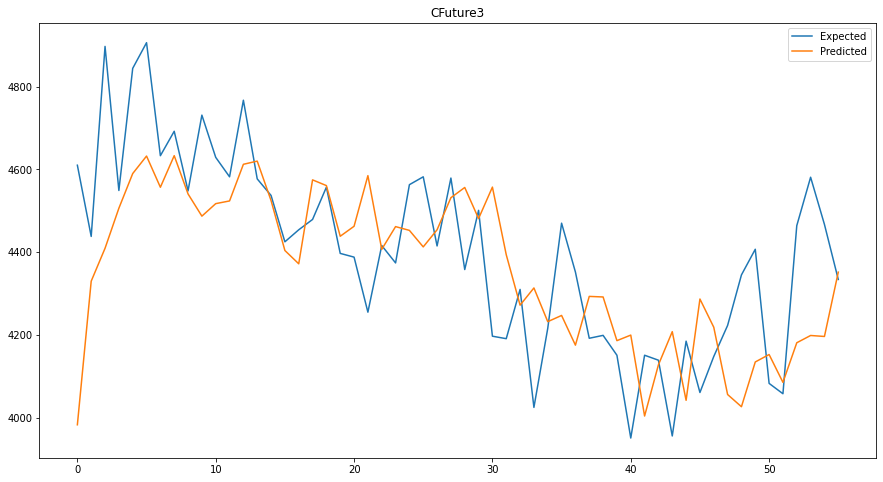

In [ ]:
y_pred = 'CFuture3'
# params optimized for CFuture3 using GridSearchCV
params={'colsample_bytree': 1, 'eta': 0.001, 'eval_metric': 'rmse', 'gamma': 0.3, 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100, 'objective': 'reg:squarederror'}
rmse3, mape3, y, yhat = walk_forward_validation(Xtrain_data, y_train[y_pred], Xtest_data, y_test[y_pred],params)
print('RMSE: %.3f' % rmse3)
print('MAPE: %.3f' % mape3)
# plot expected vs predicted
plt.figure(figsize=(15,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.title(y_pred)
plt.show()

>expected=8595.0, predicted=8549.0
>expected=9272.0, predicted=8489.9
>expected=9009.0, predicted=8853.1
>expected=9230.0, predicted=8887.2
>expected=9454.0, predicted=8969.8
>expected=9084.0, predicted=9208.5
>expected=8777.0, predicted=8991.2
>expected=9094.0, predicted=9096.6
>expected=9204.0, predicted=8929.3
>expected=9068.0, predicted=9312.8
>expected=9312.0, predicted=9168.4
>expected=8852.0, predicted=9219.9
>expected=9048.0, predicted=8775.8
>expected=8615.0, predicted=8866.5
>expected=9130.0, predicted=8925.8
>expected=8431.0, predicted=8856.8
>expected=8622.0, predicted=8518.9
>expected=8958.0, predicted=8559.7
>expected=8791.0, predicted=8774.9
>expected=8554.0, predicted=8685.7
>expected=8215.0, predicted=8710.8
>expected=8430.0, predicted=8407.2
>expected=8445.0, predicted=8320.7
>expected=8556.0, predicted=8440.9
>expected=8281.0, predicted=8351.8
>expected=8486.0, predicted=8622.3
>expected=8719.0, predicted=8320.0
>expected=8443.0, predicted=8739.8
>expected=9013.0, pr

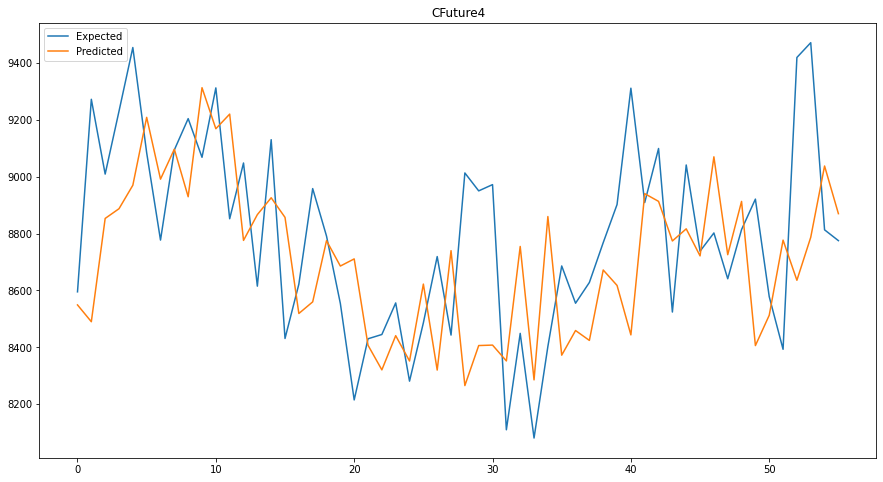

In [ ]:
y_pred = 'CFuture4'
# params optimized for CFuture4 using GridSearchCV
params = {'colsample_bytree': 0.2, 'eta': 0.001, 'eval_metric': 'rmse', 'gamma': 0.1, 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 40, 'objective': 'reg:squarederror'}
rmse4, mape4, y, yhat = walk_forward_validation(Xtrain_data, y_train[y_pred], Xtest_data, y_test[y_pred],params)
print('RMSE: %.3f' % rmse4)
print('MAPE: %.3f' % mape4)
# plot expected vs predicted
plt.figure(figsize=(15,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.title(y_pred)
plt.show()

Model1 R2 score is:  0.78


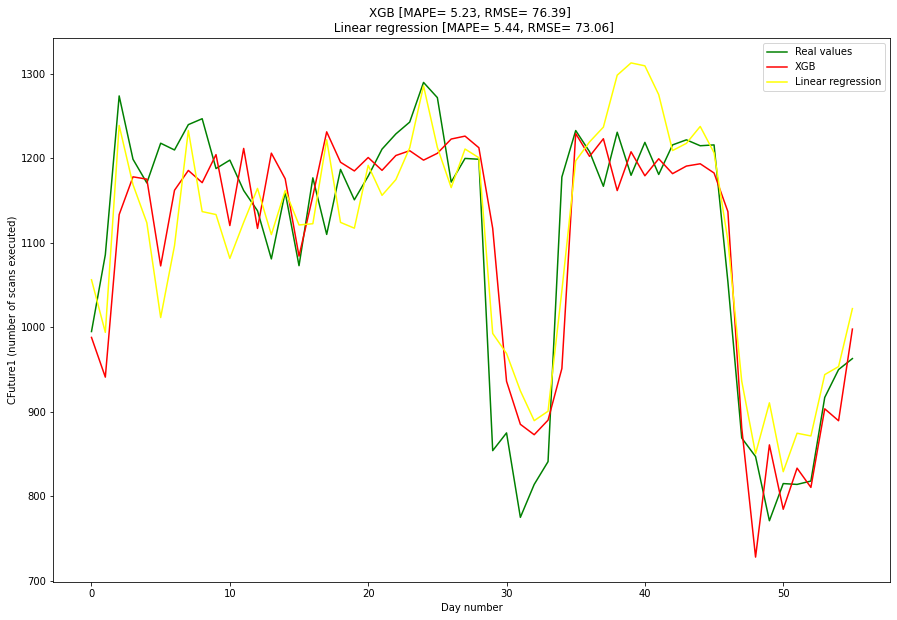

In [ ]:
# Compare with LR - CFuture1
# regression, same
from sklearn.linear_model import LinearRegression
from sklearn import metrics
# Create X and Y, compatible with sklearn (np array)
Xtrain1 = X_train.values.reshape(-1,np.size(X_train,1)); Ytrain1 = y_train.CFuture1.values.reshape(-1,1)
Xtest1 = X_test.values.reshape(-1, np.size(X_test,1)); Ytest1 = y_test.CFuture1.values.reshape(-1,1)

linear_regressor1 = LinearRegression()  # create LR
linear_regressor1.fit(Xtrain1,Ytrain1)  # fit the model
Y_pred1 = linear_regressor1.predict(Xtest1)  # predict
r2_1 = metrics.r2_score(Ytest1, Y_pred1) # R2 score
print('Model1 R2 score is: ', round(r2_1,2))
mape1= np.mean(np.abs((Ytest1 - Y_pred1) / Ytest1) * 100)
rmse1=np.sqrt(mean_squared_error(Ytest1,Y_pred1))
coeff1 = np.array2string(round(linear_regressor1.coef_[0][0], 4))
intercept1 = np.array2string(round(linear_regressor1.intercept_[0], 2))

fig, ax = plt.subplots(1,figsize=(15,10));
ax.plot(y,color='green', label='Real values')
ax.plot(yhat, color='red', label='XGB')
ax.plot(Y_pred1, color='yellow', label='Linear regression')
ax.legend()
title = 'XGB [MAPE= ' + str(round(mape,2)) + ', RMSE= ' + str(round(rmse,2)) + '] \n Linear regression [MAPE= ' + str(round(mape1,2)) + ', RMSE= ' + str(round(rmse1,2)) + ']'
ax.set_title(title)
plt.legend()
plt.ylabel('CFuture1 (number of scans executed)'); plt.xlabel('Day number')
fig.savefig('CFuture1_all_wfv6_eta0_2_maxdepth4_gamma0_4_and_LR.pdf')
fig.savefig('CFuture1_all_wfv6_eta0_2_maxdepth4_gamma0_4_and_LR.jpg')

# Remove features

In [ ]:
X_train.head()

YearDayNum  NumO1  NumO2  ...  WTYPE_Smoke_Or_Haze  dow_jones  weekly_mean_dj
0         282     64     70  ...                    0   26430.57      25605.5325
1         283     55     77  ...                    0   25598.74      25605.5325
2         284     59     92  ...                    0   25052.83      25605.5325
3         285     49     79  ...                    0   25339.99      25605.5325
4         288     44     75  ...                    0   25250.55      25515.8880

[5 rows x 50 columns]

In [ ]:
# Param optimization - loops
y_interest = 'CFuture3'
remove = ['YearDayNum','NumSF1','NumO1','NumO2','NumO3','NumO4','NumR1','NumR2','NumR3','NumR4','NumSA1','NumSA2','NumSA3','NumSA4','NumS1','NumS2','NumS3','NumS4',
          'NumC1','NumC2','NumC3','NumC4','NumSF2','NumSF3','NumSF4']
# Remove all except NumSF1 and YearDayNum (as they're most important)
X_train_reduced = X_train.drop(remove,axis=1); X_test_reduced = X_test.drop(remove,axis=1);
dtrain = xgb.DMatrix(X_train_reduced, label=y_train[y_interest]) # train data + y
dtest = xgb.DMatrix(X_test_reduced, label=y_test[y_interest]) # test data + y

# Params to loop over
eta= [0.001,0.01,0.1,0.2,0.3];
colsample_bytree= [0, 0.1, 0.2, 0.3, 0.5,0.7,0.9,1];
n_estimators= [10,20,50,60,80,90,100,120,130];
max_depth= [2,3,4,5];
min_samples_leaf= [10,20,40,80];
gamma=[0.1,0.2,0.3,0.4,0.5];

# Train
for ieta in eta:
  for idepth in max_depth:
    for igamma in gamma:
      params={
          'objective':'reg:squarederror','eval_metric':'rmse',
          'eta':ieta, 'max_depth':idepth, 'gamma':igamma
      }
      bst = xgb.train(params, dtrain,num_boost_round=100); #number of rounds -> the higher, the higher the 'feature importance'
      # Predict
      ypred = bst.predict(dtest)
      print(['\nWith eta=',ieta,'; max_depth=',idepth,'; gamma=',igamma,': '])
      print('\nRMSE" ', np.sqrt(mean_squared_error(y_test[y_interest],ypred)));
      print(xgb_mape(ypred,dtest))
# Removing all core featres except YearDayNum and NumSF1:
# CFuture1: best is eta: 0.2 and max_depth: 3
# CFuture2: best is eta=', 0.2, '; max_depth=', 2, '; gamma=', 0.3
# CFuture3: best is eta=', 0.2, '; max_depth=', 4, '; gamma=', 0.4
# CFuture4: best is

['\nWith eta=', 0.001, '; max_depth=', 2, '; gamma=', 0.1, ': ']

RMSE"  3981.3138747517146
[4610. 4438. 4897. 4549. 4844. 4906. 4633. 4692. 4548. 4731. 4629. 4582.
 4767. 4577. 4537. 4425. 4454. 4479. 4557. 4397. 4388. 4255. 4416. 4374.
 4563. 4582. 4415. 4579. 4358. 4501. 4197. 4191. 4310. 4025. 4216. 4470.
 4352. 4192. 4199. 4151. 3951. 4151. 4139. 3956. 4185. 4061. 4148. 4223.
 4345. 4407. 4083. 4058. 4464. 4581. 4467. 4334.]
('MAPE (%)', 90.256645)
['\nWith eta=', 0.001, '; max_depth=', 2, '; gamma=', 0.2, ': ']

RMSE"  3981.3138747517146
[4610. 4438. 4897. 4549. 4844. 4906. 4633. 4692. 4548. 4731. 4629. 4582.
 4767. 4577. 4537. 4425. 4454. 4479. 4557. 4397. 4388. 4255. 4416. 4374.
 4563. 4582. 4415. 4579. 4358. 4501. 4197. 4191. 4310. 4025. 4216. 4470.
 4352. 4192. 4199. 4151. 3951. 4151. 4139. 3956. 4185. 4061. 4148. 4223.
 4345. 4407. 4083. 4058. 4464. 4581. 4467. 4334.]
('MAPE (%)', 90.256645)
['\nWith eta=', 0.001, '; max_depth=', 2, '; gamma=', 0.3, ': ']

RMSE"  3981.313874

y predicted:  [ 964.1469 1250.3245 1225.2113 1175.4873 1063.0189 1170.3792 1215.8568
 1130.2609 1187.3029]
real y:               1     2     3     4     5     6     7     8     9
CFuture1  1086  1274  1199  1171  1218  1210  1240  1247  1188
CFuture2  2325  2417  2517  2435  2429  2407  2405  2412  2274
CFuture3  4438  4897  4549  4844  4906  4633  4692  4548  4731
CFuture4  9272  9009  9230  9454  9084  8777  9094  9204  9068

RMSE"  87.37544399212737
[ 995. 1086. 1274. 1199. 1171. 1218. 1210. 1240. 1247. 1188. 1198. 1162.
 1138. 1081. 1160. 1073. 1177. 1110. 1187. 1151. 1179. 1211. 1229. 1243.
 1290. 1272. 1172. 1200. 1199.  854.  875.  775.  814.  841. 1178. 1233.
 1208. 1167. 1231. 1180. 1219. 1181. 1216. 1222. 1215. 1216. 1054.  869.
  847.  771.  815.  814.  818.  917.  950.  963.]
('MAPE (%)', 6.617592)


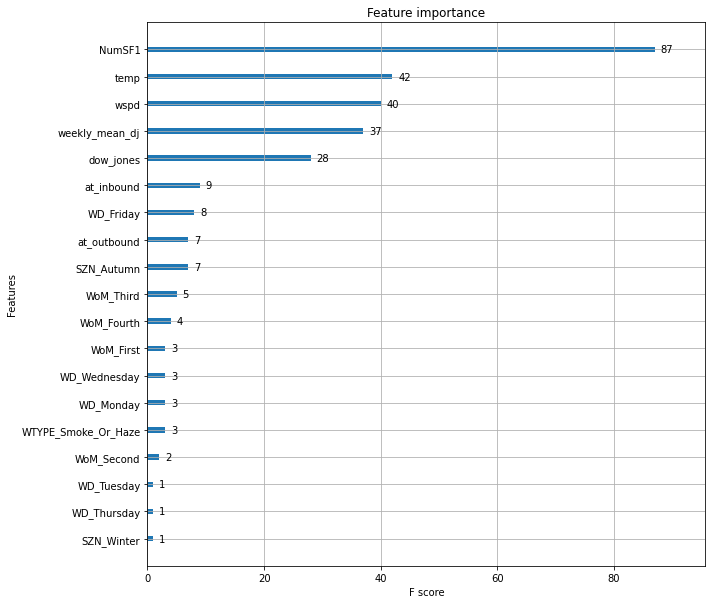

In [ ]:
params = {
    'booster':'gbtree',
    'objective': 'reg:squarederror', #'reg:linear' # not so much different output..
    'eta': 0.2, #0.001, # 0.001, 0.01, 0.1 -> this is the cause of the difference! If lower, few features used
    'max_depth': 3, #5
    'colsample_bytree': 1,
    'n_estimators': 60
    }
# Train
bst = xgb.train(params, dtrain, num_boost_round=50) #number of rounds -> the higher, the higher the 'feature importance'
# Predict
ypred = bst.predict(dtest)
print('\nRMSE" ', np.sqrt(mean_squared_error(y_test[y_interest],ypred)));
print(xgb_mape(ypred,dtest))
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(bst, ax=ax)

* Without NumSF1, RMSE is double -> NumSF1 is very important
* When other core features are removed (NumO2 etc), RMSE increases as well.
* Adding just YearDayNum & NumSF1, results in the lowest RMSE (75)
* CFuture 2-4 : much higher RMSE (200-900)
* Most important features: NumSF1, temperature, wspd, dow jones

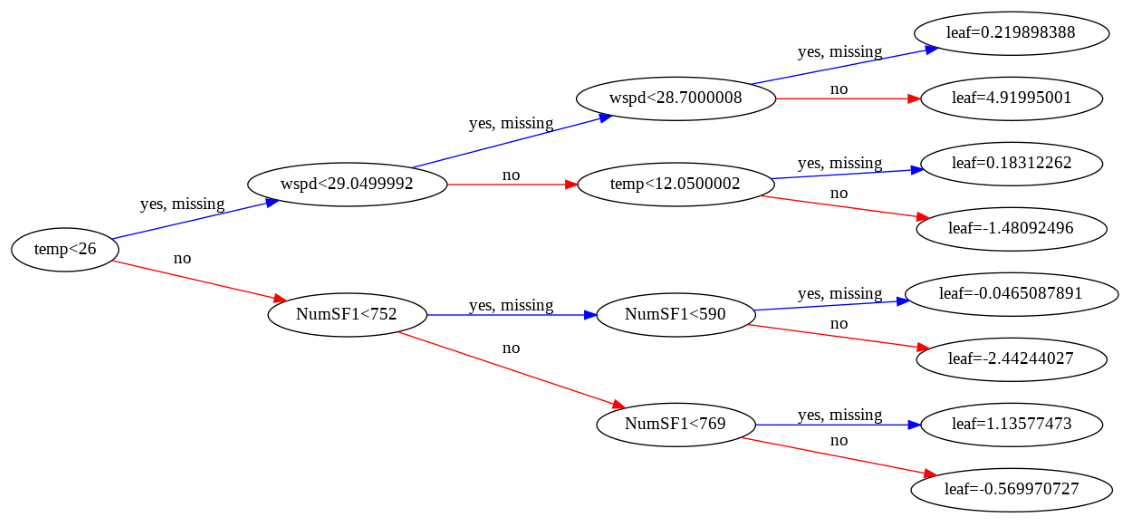

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(bst, ax=ax,rankdir="LR",num_trees=49) # needs graphviz. num_trees -> nth tree. 49= last one ()

>expected=995.0, predicted=1045.0
>expected=1086.0, predicted=1049.4
>expected=1274.0, predicted=1103.3
>expected=1199.0, predicted=1213.9
>expected=1171.0, predicted=1201.9
>expected=1218.0, predicted=1105.5
>expected=1210.0, predicted=1200.9
>expected=1240.0, predicted=1130.8
>expected=1247.0, predicted=1178.7
>expected=1188.0, predicted=1244.4
>expected=1198.0, predicted=1280.5
>expected=1162.0, predicted=1226.4
>expected=1138.0, predicted=1221.2
>expected=1081.0, predicted=1133.2
>expected=1160.0, predicted=1106.1
>expected=1073.0, predicted=1133.6
>expected=1177.0, predicted=1233.8
>expected=1110.0, predicted=1160.7
>expected=1187.0, predicted=1236.9
>expected=1151.0, predicted=1221.1
>expected=1179.0, predicted=1194.0
>expected=1211.0, predicted=1193.1
>expected=1229.0, predicted=1202.3
>expected=1243.0, predicted=1240.4
>expected=1290.0, predicted=1180.5
>expected=1272.0, predicted=1257.6
>expected=1172.0, predicted=1237.0
>expected=1200.0, predicted=1221.5
>expected=1199.0, pre

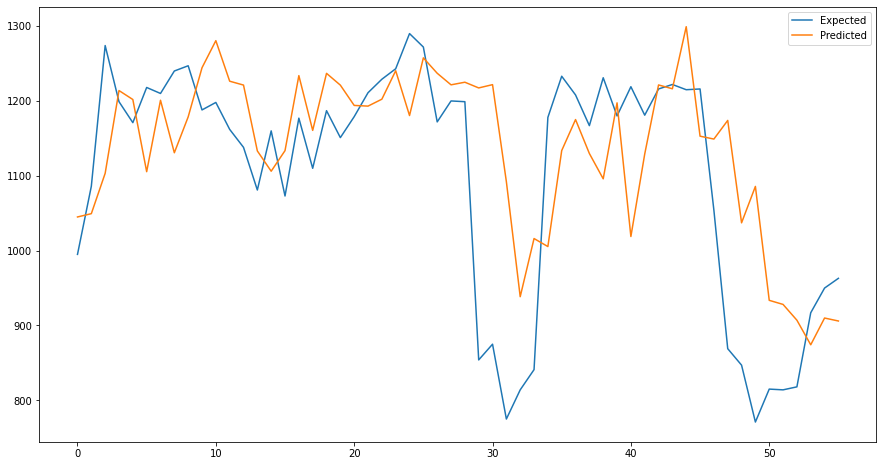

In [ ]:
# transform the time series data into supervised learning
Xtrain_data = series_to_supervised(X_train_reduced, n_in=6)
Xtest_data = series_to_supervised(X_test_reduced, n_in=6)
# evaluate
y_pred = 'CFuture1'
#future1:
params={'eta=':0.1,'max_depth': 2, 'gamma': 0.4} # eta=', 0.2, '; max_depth=', 3, '; gamma=', 0.4
rmse, mape, y, yhat, model = walk_forward_validation(Xtrain_data, y_train[y_pred], Xtest_data, y_test[y_pred],params)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
print(['Used params (optimized by GridSearchCV): ', params])
# plot expected vs preducted
plt.figure(figsize=(15,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

>expected=2340.0, predicted=1997.3
>expected=2325.0, predicted=2326.2
>expected=2417.0, predicted=2346.2
>expected=2517.0, predicted=2468.3
>expected=2435.0, predicted=2557.0
>expected=2429.0, predicted=2301.9
>expected=2407.0, predicted=2275.1
>expected=2405.0, predicted=2349.3
>expected=2412.0, predicted=2419.2
>expected=2274.0, predicted=2497.0
>expected=2281.0, predicted=2355.2
>expected=2241.0, predicted=2444.5
>expected=2287.0, predicted=2318.1
>expected=2349.0, predicted=2319.6
>expected=2326.0, predicted=2404.0
>expected=2377.0, predicted=2329.2
>expected=2440.0, predicted=2293.3
>expected=2392.0, predicted=2403.0
>expected=2455.0, predicted=2431.7
>expected=2399.0, predicted=2495.4
>expected=2420.0, predicted=2447.1
>expected=2435.0, predicted=2389.3
>expected=2385.0, predicted=2425.5
>expected=2314.0, predicted=2416.1
>expected=2168.0, predicted=2360.8
>expected=2134.0, predicted=2358.1
>expected=2010.0, predicted=2320.8
>expected=1979.0, predicted=2275.0
>expected=2069.0, pr

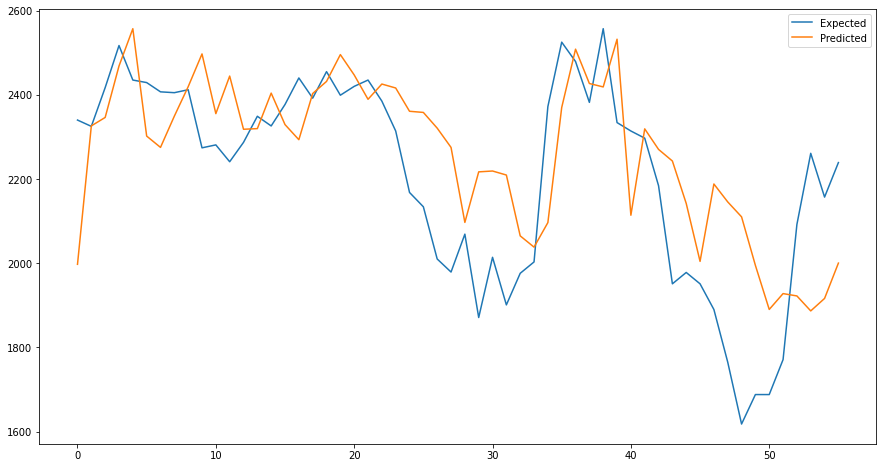

In [ ]:
# transform the time series data into supervised learning
Xtrain_data = series_to_supervised(X_train_reduced, n_in=6)
Xtest_data = series_to_supervised(X_test_reduced, n_in=6)
# evaluate
y_pred = 'CFuture2'
#future2:
params={'eta=':0.2,'max_depth': 5, 'gamma': 0.4} #eta=', 0.2, '; max_depth=', 2, '; gamma=', 0.3
rmse, mape, y, yhat, model = walk_forward_validation(Xtrain_data, y_train[y_pred], Xtest_data, y_test[y_pred],params)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
print(['Used params (optimized by GridSearchCV): ', params])
# plot expected vs preducted
plt.figure(figsize=(15,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

>expected=4610.0, predicted=3831.3
>expected=4438.0, predicted=4648.0
>expected=4897.0, predicted=4434.0
>expected=4549.0, predicted=4729.5
>expected=4844.0, predicted=4611.2
>expected=4906.0, predicted=4695.0
>expected=4633.0, predicted=4776.5
>expected=4692.0, predicted=4680.6
>expected=4548.0, predicted=4607.6
>expected=4731.0, predicted=4610.8
>expected=4629.0, predicted=4814.7
>expected=4582.0, predicted=4655.3
>expected=4767.0, predicted=4669.5
>expected=4577.0, predicted=4668.9
>expected=4537.0, predicted=4649.0
>expected=4425.0, predicted=4564.7
>expected=4454.0, predicted=4524.6
>expected=4479.0, predicted=4478.3
>expected=4557.0, predicted=4494.2
>expected=4397.0, predicted=4499.3
>expected=4388.0, predicted=4565.0
>expected=4255.0, predicted=4519.4
>expected=4416.0, predicted=4574.2
>expected=4374.0, predicted=4361.5
>expected=4563.0, predicted=4412.2
>expected=4582.0, predicted=4409.8
>expected=4415.0, predicted=4513.3
>expected=4579.0, predicted=4543.3
>expected=4358.0, pr

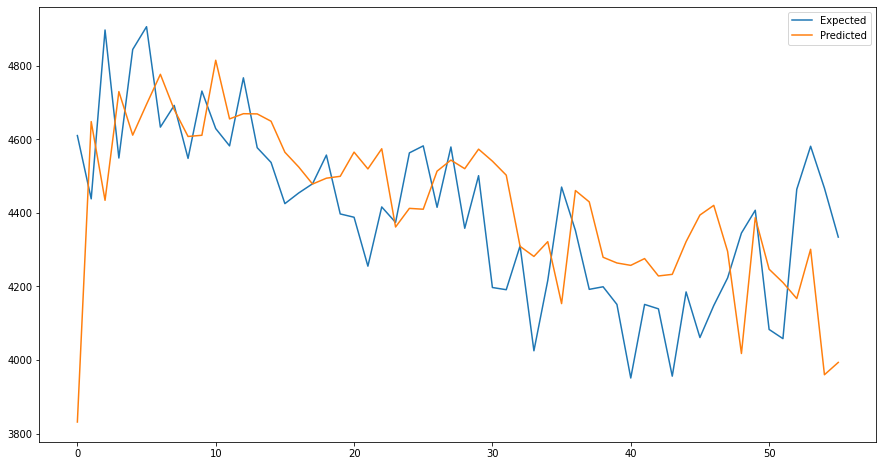

In [ ]:
# transform the time series data into supervised learning
Xtrain_data = series_to_supervised(X_train_reduced, n_in=6)
Xtest_data = series_to_supervised(X_test_reduced, n_in=6)
# evaluate
y_pred = 'CFuture3'
#future3:
params={'eta=':0.2,'max_depth':2, 'gamma': 0.4} #eta=', 0.2, '; max_depth=', 4, '; gamma=', 0.4
rmse, mape, y, yhat, model = walk_forward_validation(Xtrain_data, y_train[y_pred], Xtest_data, y_test[y_pred],params)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
print(['Used params (optimized by GridSearchCV): ', params])
# plot expected vs preducted
plt.figure(figsize=(15,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

>expected=8595.0, predicted=8449.9
>expected=9272.0, predicted=8196.2
>expected=9009.0, predicted=8408.9
>expected=9230.0, predicted=9248.6
>expected=9454.0, predicted=9233.3
>expected=9084.0, predicted=9129.4
>expected=8777.0, predicted=9059.6
>expected=9094.0, predicted=8755.9
>expected=9204.0, predicted=8963.2
>expected=9068.0, predicted=9181.5
>expected=9312.0, predicted=9077.6
>expected=8852.0, predicted=9131.5
>expected=9048.0, predicted=9027.0
>expected=8615.0, predicted=9098.4
>expected=9130.0, predicted=9103.6
>expected=8431.0, predicted=8384.7
>expected=8622.0, predicted=8271.1
>expected=8958.0, predicted=8656.6
>expected=8791.0, predicted=8628.8
>expected=8554.0, predicted=8689.8
>expected=8215.0, predicted=8489.6
>expected=8430.0, predicted=8225.9
>expected=8445.0, predicted=8975.4
>expected=8556.0, predicted=8055.6
>expected=8281.0, predicted=8315.5
>expected=8486.0, predicted=8248.7
>expected=8719.0, predicted=8374.6
>expected=8443.0, predicted=8607.7
>expected=9013.0, pr

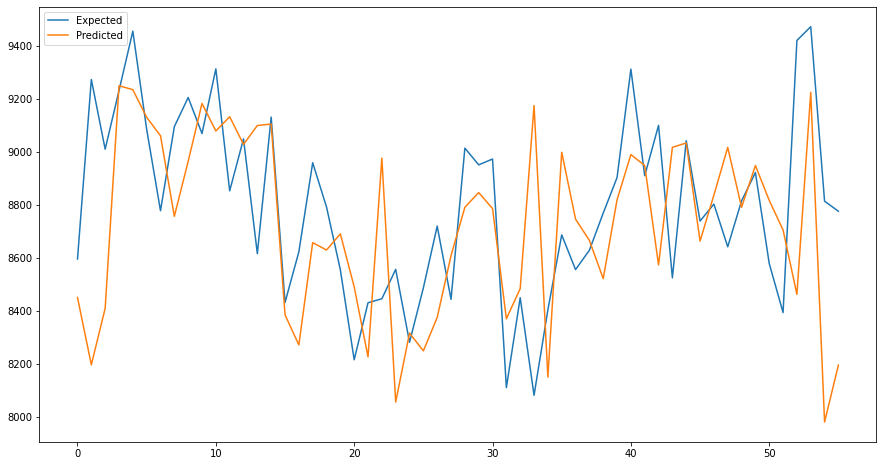

In [ ]:
# transform the time series data into supervised learning
Xtrain_data = series_to_supervised(X_train_reduced, n_in=20)
Xtest_data = series_to_supervised(X_test_reduced, n_in=20)
# evaluate
y_pred = 'CFuture4'
#future4:
# engineered f plus: params={'eta=':0.1,'max_depth': 3, 'gamma': 0.4}
params={'eta=':0.1,'max_depth': 2, 'gamma': 0.3}
rmse, mape, y, yhat, model = walk_forward_validation(Xtrain_data, y_train[y_pred], Xtest_data, y_test[y_pred],params)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
print(['Used params (optimized by GridSearchCV): ', params])
# plot expected vs preducted
plt.figure(figsize=(15,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()

# Core features

In [10]:
# import the data -selected features
X_train = pd.read_csv('train_X.csv'); X_test = pd.read_csv('test_X.csv')
y_train = pd.read_csv('train_y.csv'); y_test = pd.read_csv('test_y.csv')
print(['Size train set: ',len(X_train)]);
print(['Size test set: ',len(X_test)]);
X_train.head()

['Size train set: ', 294]
['Size test set: ', 56]


YearDayNum  NumO1  NumO2  NumO3  NumO4  NumR1  NumR2  NumR3  NumR4  NumSA1  \
0         282     64     70     95    134      4      9     14     22      80   
1         283     55     77    104    143      4      8     23     26      67   
2         284     59     92    102    140      4      6     14     22      89   
3         285     49     79     92    145      7      9     18     27      83   
4         288     44     75     94    123      7      9     11     21      62   

   ...  NumS3  NumS4  NumC1  NumC2  NumC3  NumC4  NumSF1  NumSF2  NumSF3  \
0  ...    190    188    190    387    370    375     489     887    1408   
1  ...    179    179    177    553    569    575     484     952    1414   
2  ...    191    202    197    728    742    773     536     917    1489   
3  ...    198    202    195    798    941    961     551    1002    1574   
4  ...    169    176    163    949   1111   1077     584     950    1609   

   NumSF4  
0    2067  
1    2153  
2    2107  
3    2228  
4    2158  

[5 rows x 25 columns]

In [ ]:
# Optimmize params with GridSearchCV
param_grid = {
     'eta': [0.001,0.01,0.1,0.2,0.3],
    'colsample_bytree': [0, 0.2, 0.4, 0.6,0.8,1],
    'n_estimators': [10,20,40,60,80,100,130],
    'max_depth': [2,3,4,5],
    'min_samples_leaf': [10,20,40,80],
    'objective': ['reg:squarederror'],
    'eval_metric':['rmse'], #'reg:linear'
    'gamma':[0.1,0.3,0.5]
}
xgb_model = xgb.XGBRegressor(); #XGBClassifier()
xgb1 = GridSearchCV(estimator=xgb_model, param_grid=param_grid,cv=6,scoring='neg_mean_squared_error',verbose=1);
#X_train = df_train[['at_inbound','at_outbound']]; y_train = df_train['CFuture1']

dtrain = xgb.DMatrix(X_train, label=y_train['CFuture1']); # train data + y
xgbfit = xgb1.fit(X_train,y_train['CFuture1']);

print(xgb1.best_params_);
print(xgb1.best_score_);
# Print the best parameters and lowest RMSE
print("Best parameters found: ", xgb1.best_params_);
print("Lowest RMSE found: ", np.sqrt(np.abs(xgb1.best_score_)));

#xgb.plot_importance(xgbfit) #  counting the number of times each feature is split on across all boosting rounds (trees) in the model,
#and then visualizing the result as a bar graph, with the features ordered according to how many times they appear.
#xgb.plot_tree(xgbfit, num_trees=2)

Fitting 6 folds for each of 10080 candidates, totalling 60480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 60480 out of 60480 | elapsed: 27.5min finished


{'colsample_bytree': 0.8, 'eta': 0.001, 'eval_metric': 'rmse', 'gamma': 0.1, 'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 60, 'objective': 'reg:squarederror'}
-4907.796630866028
Best parameters found:  {'colsample_bytree': 0.8, 'eta': 0.001, 'eval_metric': 'rmse', 'gamma': 0.1, 'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 60, 'objective': 'reg:squarederror'}
Lowest RMSE found:  70.05566808521654


y predicted:  [102.63099  110.893845 110.893845 110.893845 110.893845 110.893845
 110.893845 110.893845 110.893845]
real y:               1     2     3     4     5     6     7     8     9
CFuture1  1086  1274  1199  1171  1218  1210  1240  1247  1188
CFuture2  2325  2417  2517  2435  2429  2407  2405  2412  2274
CFuture3  4438  4897  4549  4844  4906  4633  4692  4548  4731
CFuture4  9272  9009  9230  9454  9084  8777  9094  9204  9068

RMSE"  1006.887934303162
[ 995. 1086. 1274. 1199. 1171. 1218. 1210. 1240. 1247. 1188. 1198. 1162.
 1138. 1081. 1160. 1073. 1177. 1110. 1187. 1151. 1179. 1211. 1229. 1243.
 1290. 1272. 1172. 1200. 1199.  854.  875.  775.  814.  841. 1178. 1233.
 1208. 1167. 1231. 1180. 1219. 1181. 1216. 1222. 1215. 1216. 1054.  869.
  847.  771.  815.  814.  818.  917.  950.  963.]
('MAPE (%)', 90.2752)


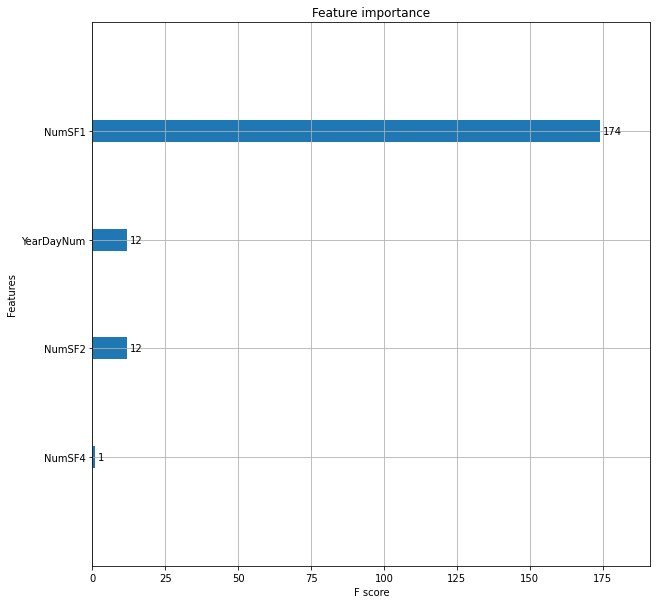

In [ ]:
# QUICK MODEL - filled in params from GridSearchCV optimization
y_interest = 'CFuture1'
dtrain = xgb.DMatrix(X_train, label=y_train[y_interest]) # train data + y
dtest = xgb.DMatrix(X_test, label=y_test[y_interest]) # test data + y
params = {
    'booster':'gbtree',
    'objective': 'reg:squarederror', #'reg:linear' # not so much different output..
    'eta': 0.001,#0.001, # 0.001, 0.01, 0.1
    'max_depth': 2,
    'colsample_bytree': 0.9,
    'n_estimators': 60,
    'gamma': 0.1,
    'min_samples_leaf': 10
    }
model = xgb.XGBRegressor();
# Train
bst = xgb.train(params, dtrain, num_boost_round=100) #number of rounds -> the higher, the higher the 'feature importance'
# early_stopping_rounds=10
#cv_results = xgb.cv(dtrain=dtrain,params=params,nfold=3,metrics='rmse',num_boost_round=50,early_stopping_rounds=10,as_pandas=True)

# Predict
ypred = bst.predict(dtest)
print('y predicted: ',ypred[1:10])
print('real y: ',y_test[1:10].T)
print('\nRMSE" ', np.sqrt(mean_squared_error(y_test[y_interest],ypred)));
print(xgb_mape(ypred,dtest))

fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(bst, ax=ax) #  counting the number of times each feature is split on across all boosting rounds (trees) in the model,
#and then visualizing the result as a bar graph, with the features ordered according to how many times they appear.
# Most important features seem: YearDayNum, all Num vars, temp, wspd, Dow Jones

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(bst, ax=ax,rankdir="LR",num_trees=99)

In [ ]:
# Param optimization - loops
y_interest = 'CFuture1'
dtrain = xgb.DMatrix(X_train, label=y_train[y_interest]) # train data + y
dtest = xgb.DMatrix(X_test, label=y_test[y_interest]) # test data + y
# Params to loop over
eta= [0.001,0.01,0.1,0.2,0.3];
colsample_bytree= [0, 0.1, 0.2, 0.3, 0.5,0.7,0.9,1];
n_estimators= [10,20,50,60,80,90,100,120,130];
max_depth= [2,3,4,5];
min_samples_leaf= [10,20,40,80];
gamma=[0.1,0.2,0.3,0.4,0.5];

# Train
for ieta in eta:
  for idepth in max_depth:
    for igamma in gamma:
      params={
          'objective':'reg:squarederror','eval_metric':'rmse',
          'eta':ieta, 'max_depth':idepth, 'gamma':igamma
      }
      bst = xgb.train(params, dtrain,num_boost_round=100); #number of rounds -> the higher, the higher the 'feature importance'
      # Predict
      ypred = bst.predict(dtest)
      print(['\nWith eta=',ieta,'; max_depth=',idepth,'; gamma=',igamma,':'])
      print('\nRMSE" ', np.sqrt(mean_squared_error(y_test[y_interest],ypred)));
      print(xgb_mape(ypred,dtest))

#fig, ax = plt.subplots(figsize=(10, 10))
#xgb.plot_importance(bst, ax=ax) #  counting the number of times each feature is split on across all boosting rounds (trees) in the model,

['\nWith eta=', 0.001, '; max_depth=', 2, '; gamma=', 0.1, ':']

RMSE"  1006.5948402583613
('MAPE (%)', 90.24927)
['\nWith eta=', 0.001, '; max_depth=', 2, '; gamma=', 0.2, ':']

RMSE"  1006.5948402583613
('MAPE (%)', 90.24927)
['\nWith eta=', 0.001, '; max_depth=', 2, '; gamma=', 0.3, ':']

RMSE"  1006.5948402583613
('MAPE (%)', 90.24927)
['\nWith eta=', 0.001, '; max_depth=', 2, '; gamma=', 0.4, ':']

RMSE"  1006.5948402583613
('MAPE (%)', 90.24927)
['\nWith eta=', 0.001, '; max_depth=', 2, '; gamma=', 0.5, ':']

RMSE"  1006.5948402583613
('MAPE (%)', 90.24927)
['\nWith eta=', 0.001, '; max_depth=', 3, '; gamma=', 0.1, ':']

RMSE"  1006.5948402583613
('MAPE (%)', 90.24927)
['\nWith eta=', 0.001, '; max_depth=', 3, '; gamma=', 0.2, ':']

RMSE"  1006.5948402583613
('MAPE (%)', 90.24927)
['\nWith eta=', 0.001, '; max_depth=', 3, '; gamma=', 0.3, ':']

RMSE"  1006.5948402583613
('MAPE (%)', 90.24927)
['\nWith eta=', 0.001, '; max_depth=', 3, '; gamma=', 0.4, ':']

RMSE"  1006.59484025836

>expected=995.0, predicted=976.5
>expected=1086.0, predicted=955.6
>expected=1274.0, predicted=1128.9
>expected=1199.0, predicted=1183.9
>expected=1171.0, predicted=1185.2
>expected=1218.0, predicted=1086.7
>expected=1210.0, predicted=1185.2
>expected=1240.0, predicted=1180.6
>expected=1247.0, predicted=1172.4
>expected=1188.0, predicted=1183.3
>expected=1198.0, predicted=1109.8
>expected=1162.0, predicted=1202.6
>expected=1138.0, predicted=1120.6
>expected=1081.0, predicted=1194.2
>expected=1160.0, predicted=1167.2
>expected=1073.0, predicted=1102.1
>expected=1177.0, predicted=1160.5
>expected=1110.0, predicted=1205.2
>expected=1187.0, predicted=1155.7
>expected=1151.0, predicted=1166.8
>expected=1179.0, predicted=1206.5
>expected=1211.0, predicted=1184.7
>expected=1229.0, predicted=1219.8
>expected=1243.0, predicted=1189.6
>expected=1290.0, predicted=1201.2
>expected=1272.0, predicted=1207.7
>expected=1172.0, predicted=1236.8
>expected=1200.0, predicted=1219.1
>expected=1199.0, predi

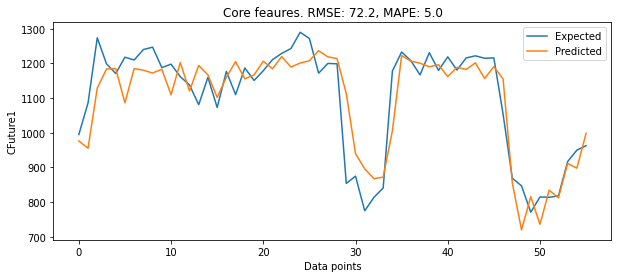

In [ ]:
# transform the time series data into supervised learning
Xtrain_data = series_to_supervised(X_train, n_in=6)
Xtest_data = series_to_supervised(X_test, n_in=6)
# evaluate
y_pred = 'CFuture1'
#future1:
params={'eta=': 0.2, 'max_depth':3, 'gamma': 0.5}
rmse, mape, y, yhat, model = walk_forward_validation(Xtrain_data, y_train[y_pred], Xtest_data, y_test[y_pred],params)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
print(['Used params (optimized by GridSearchCV): ', params])
# plot expected vs preducted
fig = plt.figure(figsize=(10,4))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.title(f'Core feaures. RMSE: {round(rmse,1)}, MAPE: {round(mape,1)}')
plt.ylabel('CFuture1'); plt.xlabel('Data points')
fig.savefig('CFuture1_core_wfv6_eta0_2_maxdepth3_gamma0_5.pdf')
fig.savefig('CFuture1_core_wfv6_eta0_2_maxdepth3_gamma0_5.jpg')

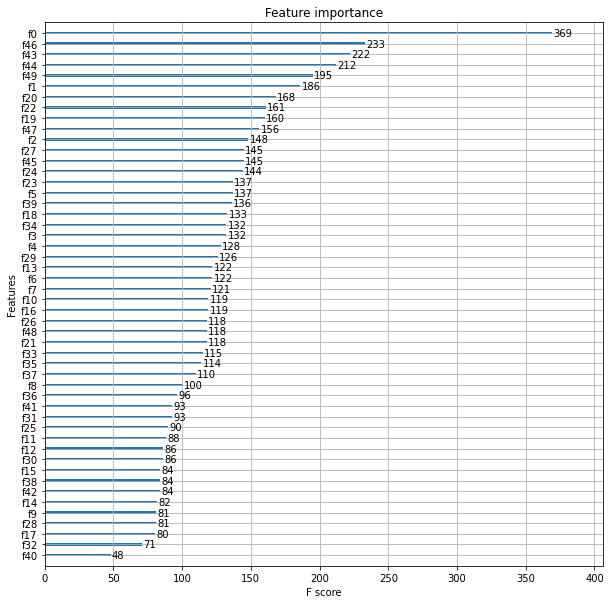

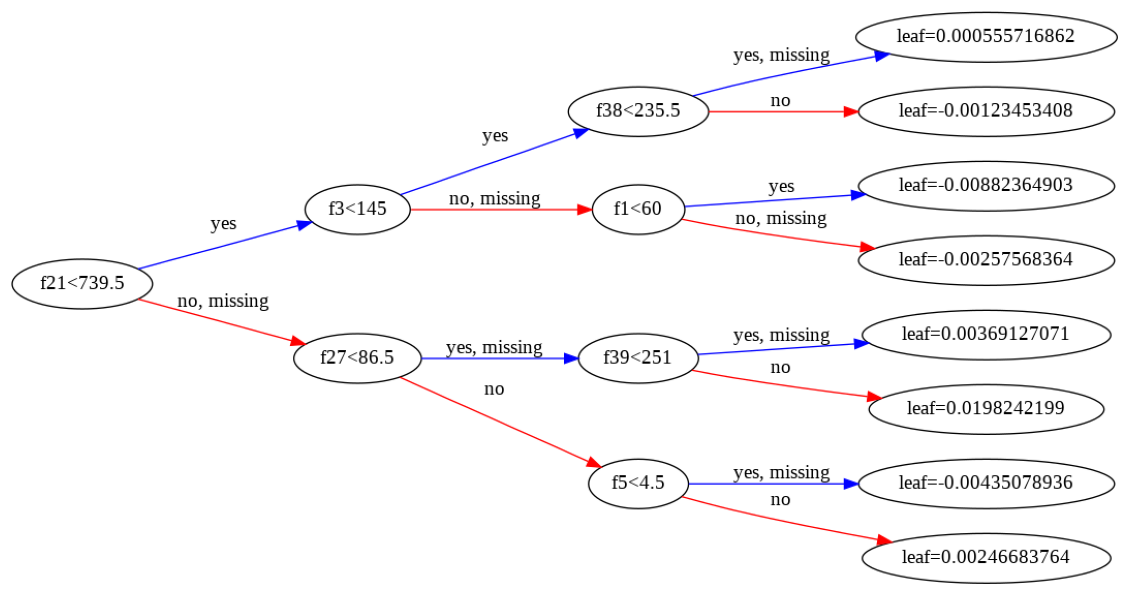

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax=ax)
fig.savefig('CFuture1_best_FeatureRanking.pdf')
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(model, ax=ax,rankdir="LR",num_trees=999)
fig.savefig('CFuture1_best_Tree.pdf')

>expected=2340.0, predicted=2184.5
>expected=2325.0, predicted=2201.0
>expected=2417.0, predicted=2384.4
>expected=2517.0, predicted=2373.8
>expected=2435.0, predicted=2411.8
>expected=2429.0, predicted=2320.7
>expected=2407.0, predicted=2239.1
>expected=2405.0, predicted=2487.3
>expected=2412.0, predicted=2452.3
>expected=2274.0, predicted=2395.3
>expected=2281.0, predicted=2343.3
>expected=2241.0, predicted=2393.9
>expected=2287.0, predicted=2340.7
>expected=2349.0, predicted=2358.1
>expected=2326.0, predicted=2394.3
>expected=2377.0, predicted=2336.8
>expected=2440.0, predicted=2426.1
>expected=2392.0, predicted=2380.5
>expected=2455.0, predicted=2353.0
>expected=2399.0, predicted=2405.7
>expected=2420.0, predicted=2344.6
>expected=2435.0, predicted=2365.5
>expected=2385.0, predicted=2354.4
>expected=2314.0, predicted=2391.8
>expected=2168.0, predicted=2110.5
>expected=2134.0, predicted=2172.0
>expected=2010.0, predicted=2190.1
>expected=1979.0, predicted=2285.8
>expected=2069.0, pr

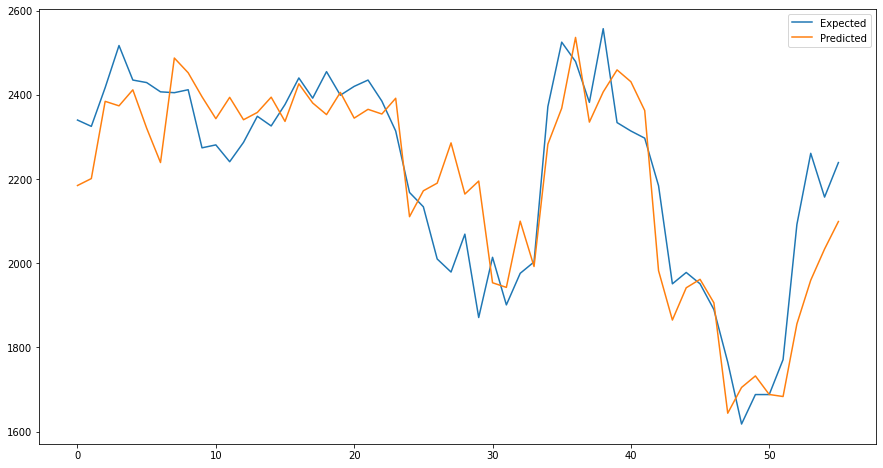

In [ ]:
# transform the time series data into supervised learning
Xtrain_data = series_to_supervised(X_train, n_in=20)
Xtest_data = series_to_supervised(X_test, n_in=20)
# evaluate
y_pred = 'CFuture2'
#future2:
params={'eta=': 0.3, 'max_depth':3, 'gamma': 0.3}
rmse, mape, y, yhat = walk_forward_validation(Xtrain_data, y_train[y_pred], Xtest_data, y_test[y_pred],params)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
print(['Used params (optimized by GridSearchCV): ', params])
# plot expected vs preducted
plt.figure(figsize=(15,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.title(f'RMSE: {rmse}, MAPE: {mape}')

>expected=4610.0, predicted=4201.4
>expected=4438.0, predicted=4349.3
>expected=4897.0, predicted=4369.9
>expected=4549.0, predicted=4533.1
>expected=4844.0, predicted=4569.2
>expected=4906.0, predicted=4467.5
>expected=4633.0, predicted=4683.8
>expected=4692.0, predicted=4619.7
>expected=4548.0, predicted=4629.1
>expected=4731.0, predicted=4481.4
>expected=4629.0, predicted=4453.5
>expected=4582.0, predicted=4522.0
>expected=4767.0, predicted=4496.9
>expected=4577.0, predicted=4513.2
>expected=4537.0, predicted=4467.3
>expected=4425.0, predicted=4243.6
>expected=4454.0, predicted=4285.1
>expected=4479.0, predicted=4556.3
>expected=4557.0, predicted=4457.7
>expected=4397.0, predicted=4457.4
>expected=4388.0, predicted=4333.3
>expected=4255.0, predicted=4545.3
>expected=4416.0, predicted=4478.0
>expected=4374.0, predicted=4324.4
>expected=4563.0, predicted=4274.1
>expected=4582.0, predicted=4332.9
>expected=4415.0, predicted=4450.1
>expected=4579.0, predicted=4474.9
>expected=4358.0, pr

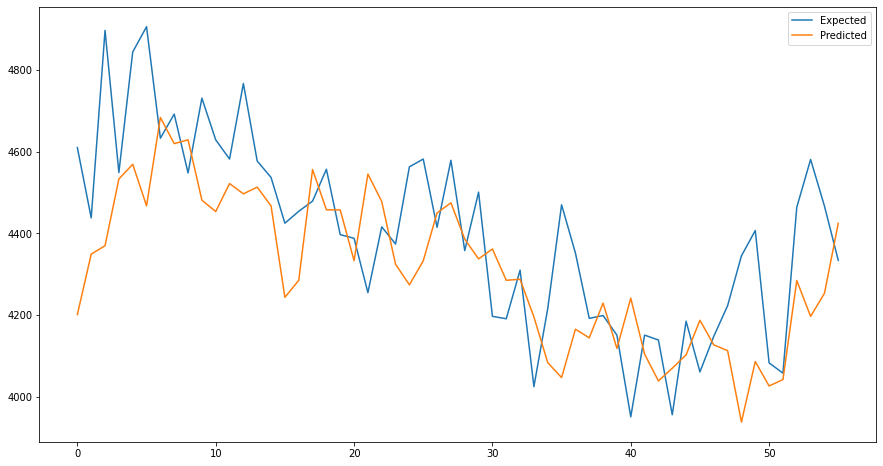

In [ ]:
# transform the time series data into supervised learning
Xtrain_data = series_to_supervised(X_train, n_in=20)
Xtest_data = series_to_supervised(X_test, n_in=20)
# evaluate
y_pred = 'CFuture3'
#future3:
params={'eta=': 0.2, 'max_depth':5, 'gamma': 0.3}
rmse, mape, y, yhat = walk_forward_validation(Xtrain_data, y_train[y_pred], Xtest_data, y_test[y_pred],params)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
print(['Used params (optimized by GridSearchCV): ', params])
# plot expected vs preducted
plt.figure(figsize=(15,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.title(f'RMSE: {rmse}, MAPE: {mape}')

>expected=8595.0, predicted=8176.3
>expected=9272.0, predicted=8391.7
>expected=9009.0, predicted=8677.8
>expected=9230.0, predicted=8931.9
>expected=9454.0, predicted=9090.0
>expected=9084.0, predicted=9202.3
>expected=8777.0, predicted=8964.3
>expected=9094.0, predicted=9136.8
>expected=9204.0, predicted=9073.9
>expected=9068.0, predicted=9068.1
>expected=9312.0, predicted=9138.3
>expected=8852.0, predicted=9156.7
>expected=9048.0, predicted=9042.2
>expected=8615.0, predicted=8810.9
>expected=9130.0, predicted=8640.6
>expected=8431.0, predicted=8600.6
>expected=8622.0, predicted=8432.0
>expected=8958.0, predicted=8583.9
>expected=8791.0, predicted=8631.9
>expected=8554.0, predicted=8610.7
>expected=8215.0, predicted=7951.5
>expected=8430.0, predicted=8362.8
>expected=8445.0, predicted=8482.5
>expected=8556.0, predicted=8319.8
>expected=8281.0, predicted=8365.8
>expected=8486.0, predicted=8570.1
>expected=8719.0, predicted=8128.8
>expected=8443.0, predicted=8711.3
>expected=9013.0, pr

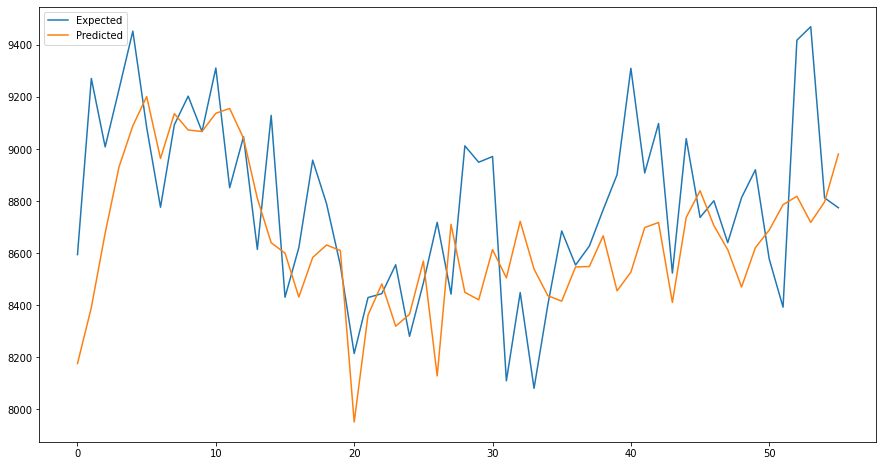

In [ ]:
# transform the time series data into supervised learning
Xtrain_data = series_to_supervised(X_train, n_in=20)
Xtest_data = series_to_supervised(X_test, n_in=20)
# evaluate
y_pred = 'CFuture4'
#future4:
params={'eta=': 0.2, 'max_depth':3, 'gamma': 0.3}
rmse, mape, y, yhat, model = walk_forward_validation(Xtrain_data, y_train[y_pred], Xtest_data, y_test[y_pred],params)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
print(['Used params (optimized by GridSearchCV): ', params])
# plot expected vs preducted
plt.figure(figsize=(15,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

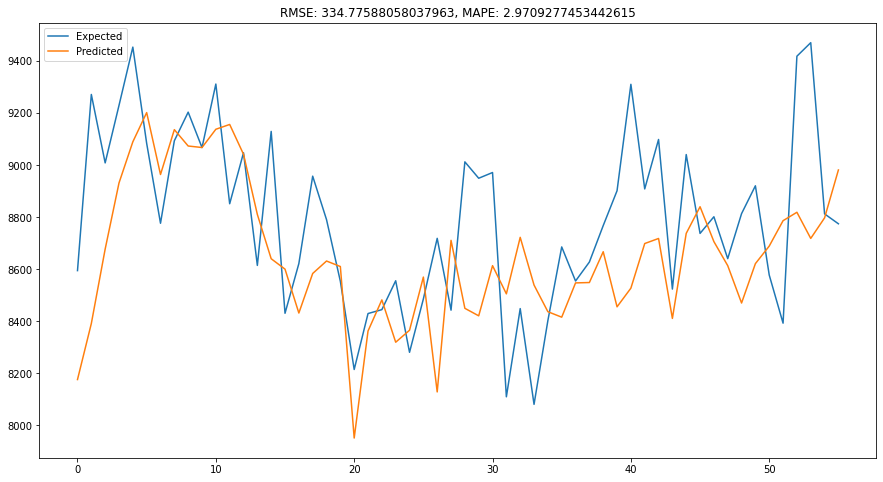

In [ ]:
# plot expected vs preducted
fig = plt.figure(figsize=(15,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.title(f'RMSE: {rmse}, MAPE: {mape}')
fig.savefig('CFuture4_bestof all_coref_wfv20_eta0-2_maxdepth3_gamma0-3.pdf')

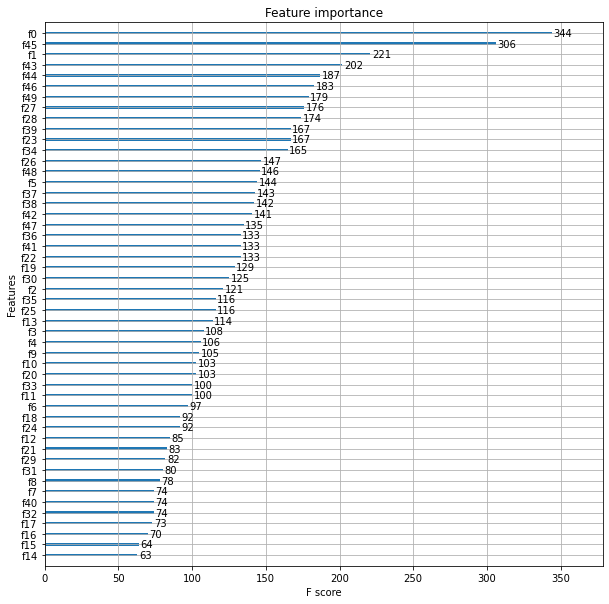

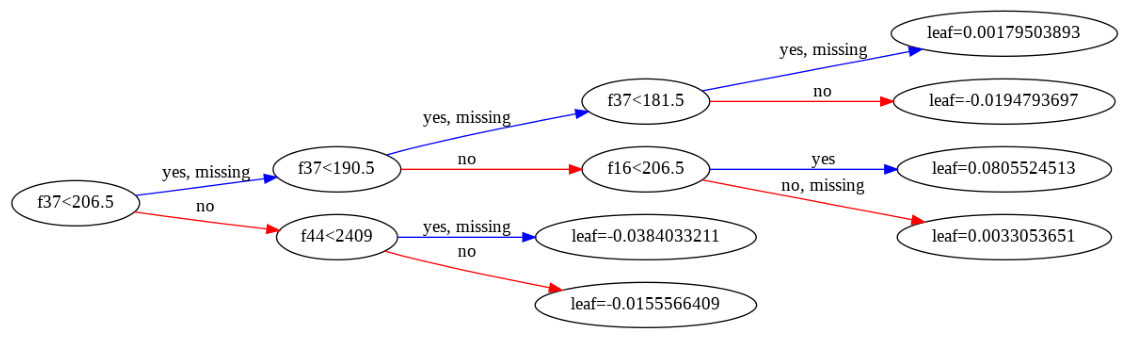

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax=ax)
fig.savefig('CFuture4_best_FeatureRanking.pdf')
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(model, ax=ax,rankdir="LR",num_trees=999)
fig.savefig('CFuture4_best_Tree.pdf')

Model1 R2 score is:  0.79


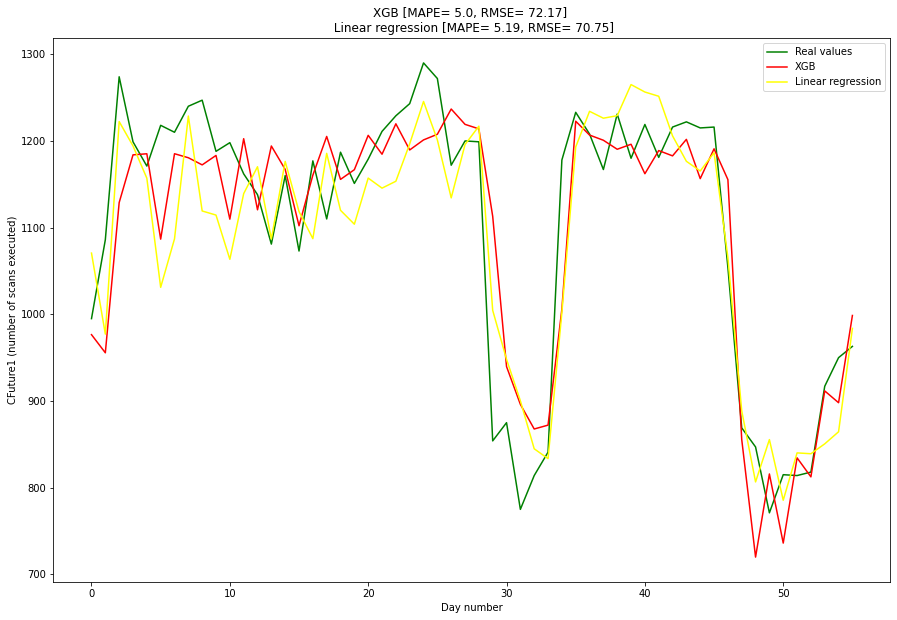

In [ ]:
# Compare with LR - CFuture1
# regression, same
from sklearn.linear_model import LinearRegression
from sklearn import metrics
# Create X and Y, compatible with sklearn (np array)
Xtrain1 = X_train.values.reshape(-1,np.size(X_train,1)); Ytrain1 = y_train.CFuture1.values.reshape(-1,1)
Xtest1 = X_test.values.reshape(-1, np.size(X_test,1)); Ytest1 = y_test.CFuture1.values.reshape(-1,1)

linear_regressor1 = LinearRegression()  # create LR
linear_regressor1.fit(Xtrain1,Ytrain1)  # fit the model
Y_pred1 = linear_regressor1.predict(Xtest1)  # predict
r2_1 = metrics.r2_score(Ytest1, Y_pred1) # R2 score
print('Model1 R2 score is: ', round(r2_1,2))
mape1= np.mean(np.abs((Ytest1 - Y_pred1) / Ytest1) * 100)
rmse1=np.sqrt(mean_squared_error(Ytest1,Y_pred1))
coeff1 = np.array2string(round(linear_regressor1.coef_[0][0], 4))
intercept1 = np.array2string(round(linear_regressor1.intercept_[0], 2))

fig, ax = plt.subplots(1,figsize=(15,10));
ax.plot(y,color='green', label='Real values')
ax.plot(yhat, color='red', label='XGB')
ax.plot(Y_pred1, color='yellow', label='Linear regression')
ax.legend()
title = 'XGB [MAPE= ' + str(round(mape,2)) + ', RMSE= ' + str(round(rmse,2)) + '] \n Linear regression [MAPE= ' + str(round(mape1,2)) + ', RMSE= ' + str(round(rmse1,2)) + ']'
ax.set_title(title)
plt.legend()
plt.ylabel('CFuture1 (number of scans executed)'); plt.xlabel('Day number')
fig.savefig('CFuture1_core_wfv6_eta0_2_maxdepth4_gamma0_4_and_LR.pdf')
fig.savefig('CFuture1_core_wfv6_eta0_2_maxdepth4_gamma0_4_and_LR.jpg')

# Check contribution of YearDayNum and NumSF1 vs the other core features

In [ ]:
# Optimize params model1 and model2
X_train = pd.read_csv('train_X.csv'); X_test = pd.read_csv('test_X.csv')
y_train = pd.read_csv('train_y.csv'); y_test = pd.read_csv('test_y.csv')
# 1. Train & predict using only YearDayNum and NumSF1
# Param optimization - loops
x_interest = ['YearDayNum','NumSF1']; y_interest = 'CFuture1'
dtrain1 = xgb.DMatrix(X_train[x_interest], label=y_train[y_interest]) # train data + y
dtest1 = xgb.DMatrix(X_test[x_interest], label=y_test[y_interest]) # test data + y

# Params to loop over
eta= [0.001,0.01,0.1,0.2,0.3];
max_depth= [2,3,4,5];
gamma=[0.1,0.2,0.3,0.4,0.5];
for ieta in eta:
  for idepth in max_depth:
    for igamma in gamma:
      params={
          'objective':'reg:squarederror','eval_metric':'rmse',
          'eta':ieta, 'max_depth':idepth, 'gamma':igamma
      }
      bst = xgb.train(params, dtrain1,num_boost_round=100); #number of rounds -> the higher, the higher the 'feature importance'
      # Predict
      ypred = bst.predict(dtest1)
      print(['\nWith eta=',ieta,'; max_depth=',idepth,'; gamma=',igamma,': '])
      print('\nRMSE" ', np.sqrt(mean_squared_error(y_test[y_interest],ypred)));
      print(xgb_mape(ypred,dtest1)); print('\n')
# Best: MAPE (%)= 6.086136; RMSE=76.9717 with params: eta=', 0.2, '; max_depth=', 2, '; gamma=', 0.4 (actually gamma doesn´t make a difference)

# Model2
remove = ['NumSF2','NumSF3','NumSF4']; y_interest = 'CFuture1'
dtrain2 = xgb.DMatrix(X_train.drop(remove,axis=1), label=y_train[y_interest]) # train data + y
dtest2 = xgb.DMatrix(X_test.drop(remove,axis=1), label=y_test[y_interest]) # test data + y
# optimize params
for ieta in eta:
  for idepth in max_depth:
    for igamma in gamma:
      params={
          'objective':'reg:squarederror','eval_metric':'rmse',
          'eta':ieta, 'max_depth':idepth, 'gamma':igamma
      }
      bst = xgb.train(params, dtrain2,num_boost_round=100); #number of rounds -> the higher, the higher the 'feature importance'
      # Predict
      ypred = bst.predict(dtest2)
      print(['\nWith eta=',ieta,'; max_depth=',idepth,'; gamma=',igamma,': '])
      print('\nRMSE" ', np.sqrt(mean_squared_error(y_test[y_interest],ypred)));
      print(xgb_mape(ypred,dtest2)); print('\n')
#Optimized: eta=', 0.2, '; max_depth=', 2, '; gamma=', 0.4
#RMSE"  73.07870298196617
#('MAPE (%)', 5.447029)

['\nWith eta=', 0.001, '; max_depth=', 2, '; gamma=', 0.1, ': ']

RMSE"  1006.5948402583613
('MAPE (%)', 90.24927)


['\nWith eta=', 0.001, '; max_depth=', 2, '; gamma=', 0.2, ': ']

RMSE"  1006.5948402583613
('MAPE (%)', 90.24927)


['\nWith eta=', 0.001, '; max_depth=', 2, '; gamma=', 0.3, ': ']

RMSE"  1006.5948402583613
('MAPE (%)', 90.24927)


['\nWith eta=', 0.001, '; max_depth=', 2, '; gamma=', 0.4, ': ']

RMSE"  1006.5948402583613
('MAPE (%)', 90.24927)


['\nWith eta=', 0.001, '; max_depth=', 2, '; gamma=', 0.5, ': ']

RMSE"  1006.5948402583613
('MAPE (%)', 90.24927)


['\nWith eta=', 0.001, '; max_depth=', 3, '; gamma=', 0.1, ': ']

RMSE"  1006.5948402583613
('MAPE (%)', 90.24927)


['\nWith eta=', 0.001, '; max_depth=', 3, '; gamma=', 0.2, ': ']

RMSE"  1006.5948402583613
('MAPE (%)', 90.24927)


['\nWith eta=', 0.001, '; max_depth=', 3, '; gamma=', 0.3, ': ']

RMSE"  1006.5948402583613
('MAPE (%)', 90.24927)


['\nWith eta=', 0.001, '; max_depth=', 3, '; gamma=', 0.4, ': ']

>expected=995.0, predicted=1053.5
>expected=1086.0, predicted=992.9
>expected=1274.0, predicted=1051.2
>expected=1199.0, predicted=1229.6
>expected=1171.0, predicted=1168.5
>expected=1218.0, predicted=1030.2
>expected=1210.0, predicted=1132.5
>expected=1240.0, predicted=1220.7
>expected=1247.0, predicted=1261.1
>expected=1188.0, predicted=1228.3
>expected=1198.0, predicted=1092.2
>expected=1162.0, predicted=1228.8
>expected=1138.0, predicted=1166.6
>expected=1081.0, predicted=1154.3
>expected=1160.0, predicted=1120.1
>expected=1073.0, predicted=1165.4
>expected=1177.0, predicted=1116.9
>expected=1110.0, predicted=1174.0
>expected=1187.0, predicted=1110.3
>expected=1151.0, predicted=1146.5
>expected=1179.0, predicted=1135.3
>expected=1211.0, predicted=1129.7
>expected=1229.0, predicted=1139.8
>expected=1243.0, predicted=1148.8
>expected=1290.0, predicted=1232.2
>expected=1272.0, predicted=1233.3
>expected=1172.0, predicted=1199.1
>expected=1200.0, predicted=1197.7
>expected=1199.0, pred

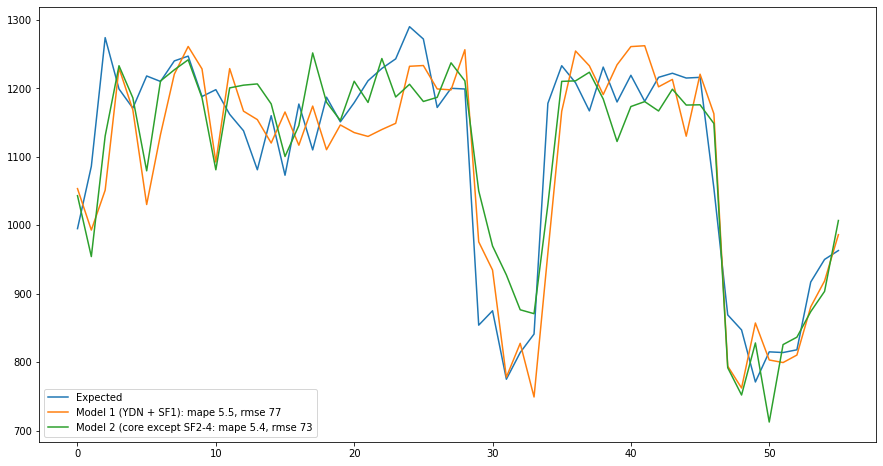

In [ ]:
# Test both models
params1={'eta': 0.2, 'max_depth': 2, 'gamma': 0.4}
Xtrain1 = series_to_supervised(X_train[x_interest], n_in=6); Xtest1 = series_to_supervised(X_test[x_interest], n_in=6)
rmse1, mape1, y1, yhat1, model1 = walk_forward_validation(Xtrain1, y_train[y_interest], Xtest1, y_test[y_interest],params1)

params2 = {'eta': 0.2, 'max_depth':2,'gamma':0.4}
Xtrain2 = series_to_supervised(X_train.drop(labels=remove,axis=1), n_in=6); Xtest2 = series_to_supervised(X_test.drop(labels=remove,axis=1), n_in=6)
rmse2, mape2, y2, yhat2, model2 = walk_forward_validation(Xtrain2, y_train[y_interest], Xtest2, y_test[y_interest],params2)

print('Model 1 - trained on only YearDayNum and NumSF1: ')
print(['\nRMSE: ', rmse1,'; MAPE: ',mape1]);
print('Model 2 - trained on core features except NumSF2,3,4')
print(['\nRMSE: ', rmse2,'; MAPE: ',mape2]);

fig = plt.figure(figsize=(15,8))
plt.plot(y1, label='Expected')
plt.plot(yhat1, label='Model 1 (YDN + SF1): mape 5.5, rmse 77')
plt.plot(yhat2, label='Model 2 (core except SF2-4: mape 5.4, rmse 73')
plt.legend()
fig.savefig('CFuture1_model1_vs_model2_wfv6.pdf')

Model1 R2 score is:  0.8
Model1 R2 score is:  0.78


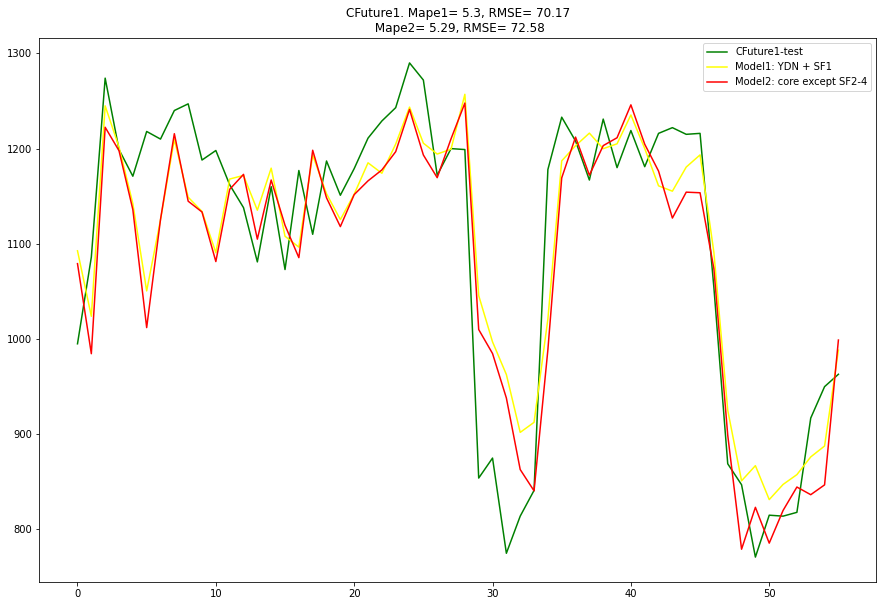

In [ ]:
# regression, same
from sklearn.linear_model import LinearRegression
from sklearn import metrics
# Create X and Y, compatible with sklearn (np array)
Xtrain1 = X_train[x_interest].values.reshape(-1,np.size(X_train[x_interest],1)); Ytrain1 = y_train.CFuture1.values.reshape(-1,1)  # model1
Xtest1 = X_test[x_interest].values.reshape(-1, np.size(X_test[x_interest],1)); Ytest1 = y_test.CFuture1.values.reshape(-1,1)

Xtrain2 = X_train.drop(labels=remove,axis=1).values.reshape(-1,np.size(X_train.drop(labels=remove,axis=1),1)) # model2
Xtest2 = X_test.drop(labels=remove,axis=1).values.reshape(-1,np.size(X_test.drop(labels=remove,axis=1),1))
Ytrain2 = y_train.CFuture1.values.reshape(-1,1); Ytest2 = y_test.CFuture1.values.reshape(-1,1) # future 1

linear_regressor1 = LinearRegression()  # create LR
linear_regressor1.fit(Xtrain1,Ytrain1)  # fit the model
Y_pred1 = linear_regressor1.predict(Xtest1)  # predict
r2_1 = metrics.r2_score(Ytest1, Y_pred1) # R2 score
print('Model1 R2 score is: ', round(r2_1,2))
mape1= np.mean(np.abs((Ytest1 - Y_pred1) / Ytest1) * 100)
rmse1=np.sqrt(mean_squared_error(Ytest1,Y_pred1))
coeff1 = np.array2string(round(linear_regressor1.coef_[0][0], 4))
intercept1 = np.array2string(round(linear_regressor1.intercept_[0], 2))

linear_regressor2 = LinearRegression()  # create LR
linear_regressor2.fit(Xtrain2,Ytrain2)  # fit the model
Y_pred2 = linear_regressor2.predict(Xtest2)  # predict
r2_2 = metrics.r2_score(Ytest2, Y_pred2) # R2 score
print('Model1 R2 score is: ', round(r2_2,2))
mape2= np.mean(np.abs((Ytest2 - Y_pred2) / Ytest2) * 100)
rmse2=np.sqrt(mean_squared_error(Ytest2,Y_pred2))
coeff2 = np.array2string(round(linear_regressor2.coef_[0][0], 4))
intercept2 = np.array2string(round(linear_regressor2.intercept_[0], 2))

fix, ax = plt.subplots(1,figsize=(15,10));
ax.plot(Ytest1,color='green', label='CFuture1-test')
ax.plot(Y_pred1, color='yellow', label='Model1: YDN + SF1')
ax.plot(Y_pred2, color='red', label='Model2: core except SF2-4')
ax.legend()
title = 'CFuture1. Mape1= ' + str(round(mape1,2)) + ', RMSE= ' + str(round(rmse1,2)) + '\n Mape2= ' + str(round(mape2,2)) + ', RMSE= ' + str(round(rmse2,2))
ax.set_title(title)
fix.savefig('CFuture1_model1_vs_model2_linearRegression.pdf') # save figure

# Test on COVID19 data

>expected=1229.0, predicted=1157.7
>expected=1162.0, predicted=1198.2
>expected=1217.0, predicted=1200.3
>expected=1235.0, predicted=1215.1
>expected=1183.0, predicted=1213.5
>expected=1007.0, predicted=914.7
>expected=936.0, predicted=936.0
>expected=927.0, predicted=927.0
>expected=964.0, predicted=964.0
>expected=934.0, predicted=934.0
>expected=1138.0, predicted=1138.0
>expected=1124.0, predicted=1124.0
>expected=1127.0, predicted=1127.0
>expected=1154.0, predicted=1154.0
>expected=1232.0, predicted=1232.0
>expected=1259.0, predicted=1259.0
>expected=1289.0, predicted=1289.0
>expected=1281.0, predicted=1281.0
>expected=1223.0, predicted=1223.0
>expected=1292.0, predicted=1218.5
>expected=1185.0, predicted=1186.0
>expected=1270.0, predicted=1245.2
>expected=1150.0, predicted=1227.8
>expected=1189.0, predicted=1182.7
>expected=1018.0, predicted=1141.1
>expected=855.0, predicted=913.1
>expected=726.0, predicted=788.8
>expected=602.0, predicted=776.1
>expected=481.0, predicted=637.1
>e

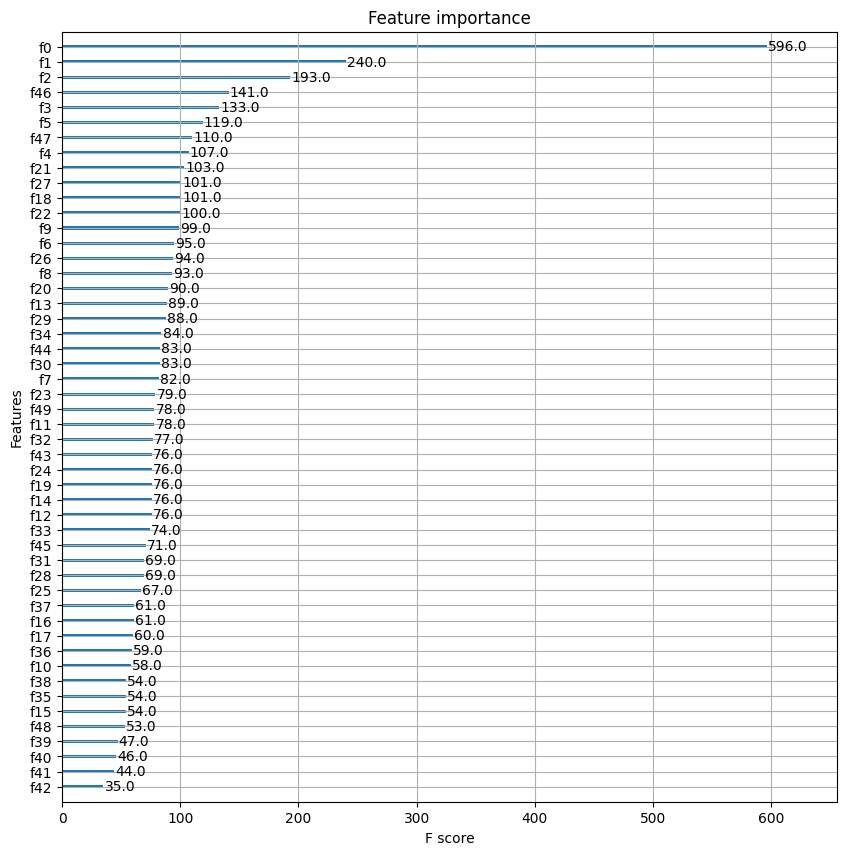

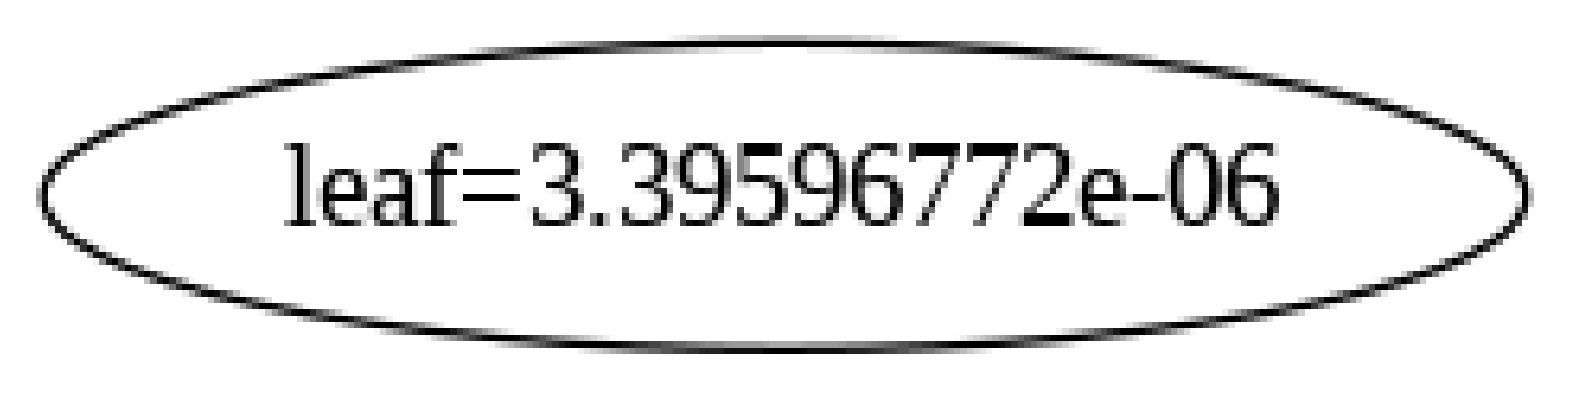

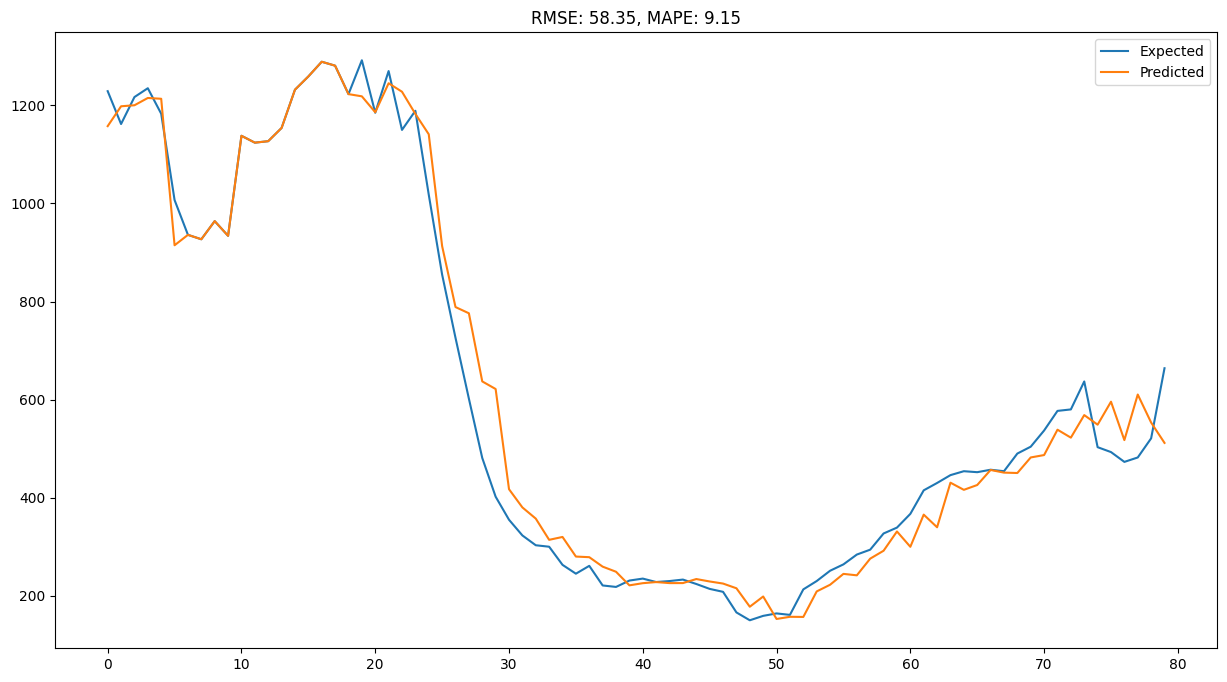

In [11]:
# Test on Covid19 data - core features
# concat train + test data
X_train_add = pd.concat([X_train, X_test])
y_train_add = pd.concat([y_train, y_test])
# find covid data
df = pd.read_excel('ModelData_Cleaned.xlsx');
data_covid = df[df['Date'] > '2020-02-01'][0:80] # cut off the data points > 80 or after 26-520 (as they're inaccurate)
data_covid = data_covid.drop(labels=["Date",'CWeekDay','CCoronaRelDateNum','CCoronaRelWeekNum','CWeekNumYear'],axis=1)
data_covid.head()
X_test_covid = data_covid.drop(labels=["CFuture1","CFuture2","CFuture3","CFuture4"],axis=1)
y_test_covid = data_covid[["CFuture1","CFuture2","CFuture3","CFuture4"]]

Xtrain_data = series_to_supervised(X_train_add, n_in=6)
Xtest_data = series_to_supervised(X_test_covid, n_in=6)
# evaluate on
y_pred = 'CFuture1'
#future1:
params={'eta=': 0.2, 'max_depth':3, 'gamma': 0.5} # best params for core features & CFuture1
rmse, mape, y, yhat, model = walk_forward_validation(Xtrain_data, y_train_add[y_pred], Xtest_data, y_test_covid[y_pred],params)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
print(['Used params: ', params])

fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax=ax)
#fig.savefig('CFuture1_core_best_FeatureRanking_covid_data.pdf')
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(model, ax=ax,rankdir="LR",num_trees=999)
#fig.savefig('CFuture1_core_best_Tree_covid_data.pdf')
fig = plt.figure(figsize=(15,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.title(f'RMSE: {round(rmse,2)}, MAPE: {round(mape,2)}')
fig.savefig('CFuture1_core_COVIDreduced_wfv6_eta0-2_maxdepth3_gamma0-5.pdf')

>expected=2216.0, predicted=2040.9
>expected=2257.0, predicted=2237.6
>expected=2172.0, predicted=2258.3
>expected=2225.0, predicted=2082.3
>expected=2184.0, predicted=2152.6
>expected=2112.0, predicted=2146.2
>expected=2191.0, predicted=2191.2
>expected=2212.0, predicted=2211.9
>expected=2212.0, predicted=2211.9
>expected=2126.0, predicted=2125.8
>expected=2366.0, predicted=2366.0
>expected=2367.0, predicted=2367.0
>expected=2364.0, predicted=2363.9
>expected=2342.0, predicted=2342.2
>expected=2417.0, predicted=2417.3
>expected=2476.0, predicted=2475.8
>expected=2551.0, predicted=2551.1
>expected=2527.0, predicted=2526.5
>expected=2489.0, predicted=2489.0
>expected=2397.0, predicted=2399.3
>expected=2065.0, predicted=2344.4
>expected=1927.0, predicted=2180.9
>expected=1752.0, predicted=2006.8
>expected=1574.0, predicted=1878.4
>expected=1474.0, predicted=1684.3
>expected=1256.0, predicted=1405.9
>expected=1009.0, predicted=1294.3
>expected=926.0, predicted=1254.1
>expected=780.0, pred

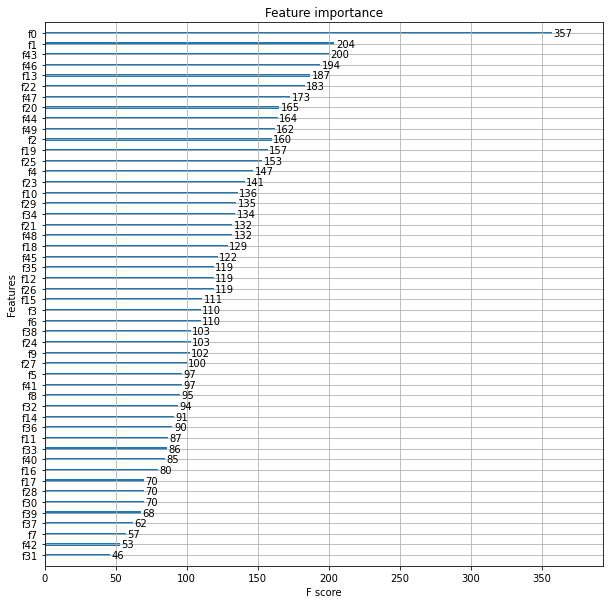

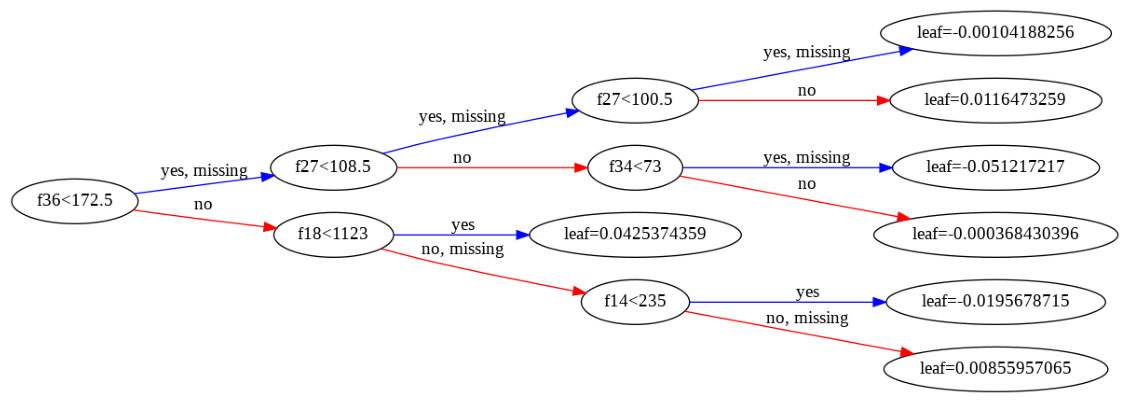

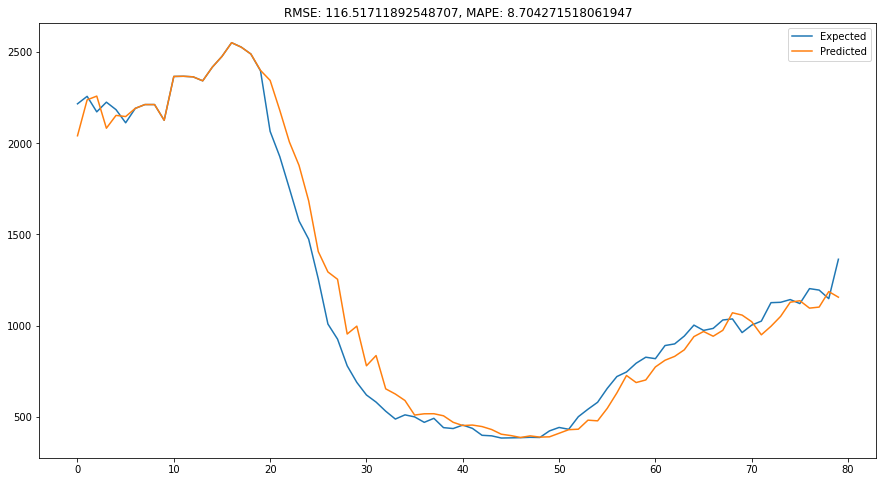

In [ ]:
# evaluate on
y_pred = 'CFuture2'
Xtrain_data = series_to_supervised(X_train_add, n_in=6)
Xtest_data = series_to_supervised(X_test_covid, n_in=6)
#future2:
params={'eta=': 0.3, 'max_depth':3, 'gamma': 0.3} # best params for core features & CFuture2
rmse, mape, y, yhat, model = walk_forward_validation(Xtrain_data, y_train_add[y_pred], Xtest_data, y_test_covid[y_pred],params)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
print(['Used params: ', params])

fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax=ax)
#fig.savefig('CFuture2_core_best_FeatureRanking_covid_data.pdf')
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(model, ax=ax,rankdir="LR",num_trees=999)
#fig.savefig('CFuture2_core_best_Tree_covid_data.pdf')
fig = plt.figure(figsize=(15,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.title(f'RMSE: {rmse}, MAPE: {mape}')
fig.savefig('CFuture2_core_COVIDreduced_wfv6_eta0-3_maxdepth3_gamma0-3.pdf')

>expected=4632.0, predicted=4292.8
>expected=4644.0, predicted=4374.5
>expected=4601.0, predicted=4534.8
>expected=4822.0, predicted=4563.5
>expected=4783.0, predicted=4548.2
>expected=4760.0, predicted=4570.7
>expected=4389.0, predicted=4535.9
>expected=4595.0, predicted=4528.4
>expected=4744.0, predicted=4563.6
>expected=4403.0, predicted=4439.5
>expected=4526.0, predicted=4518.0
>expected=4276.0, predicted=4276.3
>expected=4317.0, predicted=4272.5
>expected=4198.0, predicted=4154.6
>expected=4096.0, predicted=4148.2
>expected=3629.0, predicted=4009.4
>expected=3421.0, predicted=3737.2
>expected=3291.0, predicted=3619.8
>expected=3171.0, predicted=3235.9
>expected=2900.0, predicted=3461.4
>expected=2705.0, predicted=3119.9
>expected=2635.0, predicted=3219.0
>expected=2342.0, predicted=2751.4
>expected=2157.0, predicted=2790.9
>expected=2011.0, predicted=2387.1
>expected=1784.0, predicted=2228.6
>expected=1506.0, predicted=2235.9
>expected=1426.0, predicted=1755.9
>expected=1184.0, pr

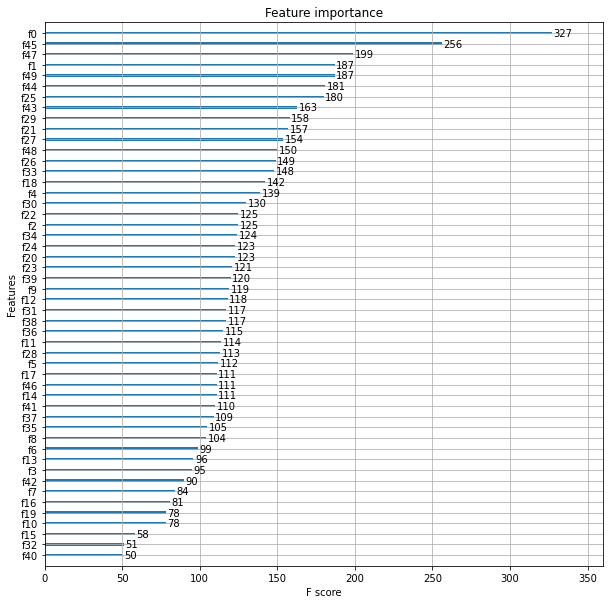

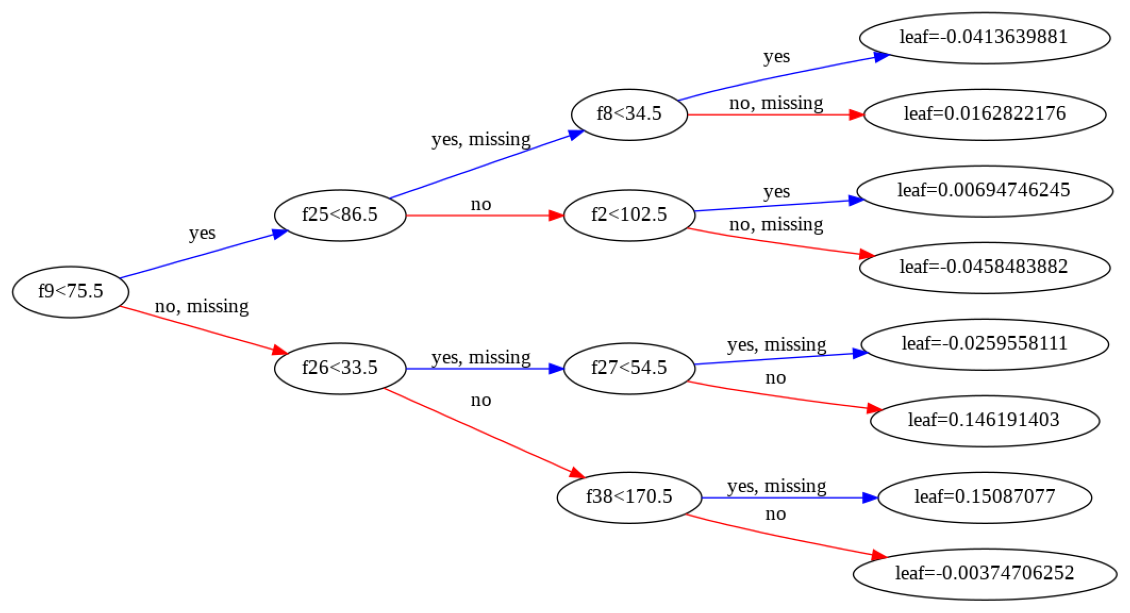

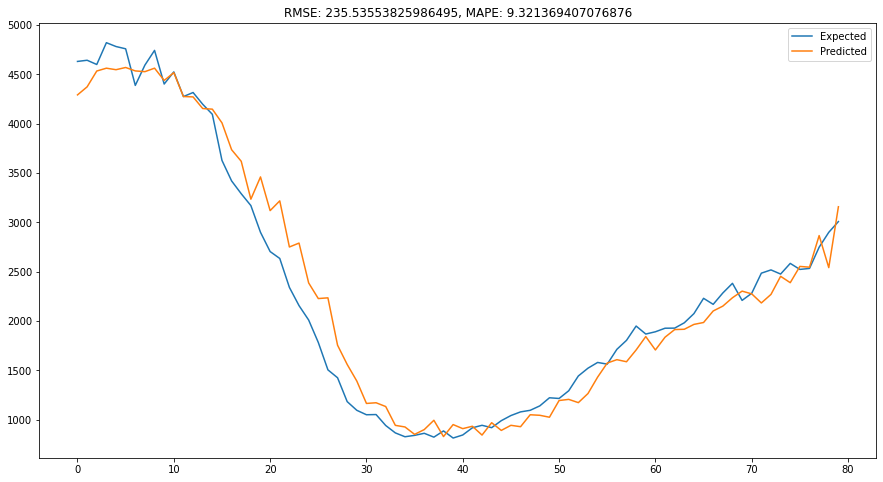

In [ ]:
# evaluate on
y_pred = 'CFuture3'
Xtrain_data = series_to_supervised(X_train_add, n_in=20)
Xtest_data = series_to_supervised(X_test_covid, n_in=20)
#future3:
params={'eta=': 0.2, 'max_depth':5, 'gamma': 0.3} # best params for core features & CFuture2
rmse, mape, y, yhat, model = walk_forward_validation(Xtrain_data, y_train_add[y_pred], Xtest_data, y_test_covid[y_pred],params)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
print(['Used params: ', params])

fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax=ax)
fig.savefig('CFuture3_core_best_FeatureRanking_covid_data.pdf')
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(model, ax=ax,rankdir="LR",num_trees=999)
fig.savefig('CFuture3_core_best_Tree_covid_data.pdf')
fig = plt.figure(figsize=(15,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.title(f'RMSE: {rmse}, MAPE: {mape}')
fig.savefig('CFuture3_core_COVIDreduced_wfv20_eta0-2_maxdepth5_gamma0-3.pdf')

>expected=7875.0, predicted=7903.9
>expected=7433.0, predicted=7367.9
>expected=7111.0, predicted=7678.8
>expected=6812.0, predicted=7248.4
>expected=6673.0, predicted=7452.1
>expected=6249.0, predicted=6754.7
>expected=6468.0, predicted=7074.2
>expected=6447.0, predicted=6601.7
>expected=5831.0, predicted=6223.2
>expected=5941.0, predicted=6463.4
>expected=5376.0, predicted=5888.3
>expected=5494.0, predicted=5522.2
>expected=5281.0, predicted=5369.0
>expected=4778.0, predicted=5587.3
>expected=4897.0, predicted=5288.8
>expected=4534.0, predicted=5068.2
>expected=4376.0, predicted=5007.5
>expected=4269.0, predicted=4457.1
>expected=3942.0, predicted=4490.9
>expected=3933.0, predicted=4229.1
>expected=3640.0, predicted=5847.7
>expected=3371.0, predicted=3706.5
>expected=3196.0, predicted=3676.0
>expected=3042.0, predicted=3817.3
>expected=2854.0, predicted=3101.8
>expected=2629.0, predicted=3106.4
>expected=2480.0, predicted=2806.9
>expected=2418.0, predicted=2826.0
>expected=2335.0, pr

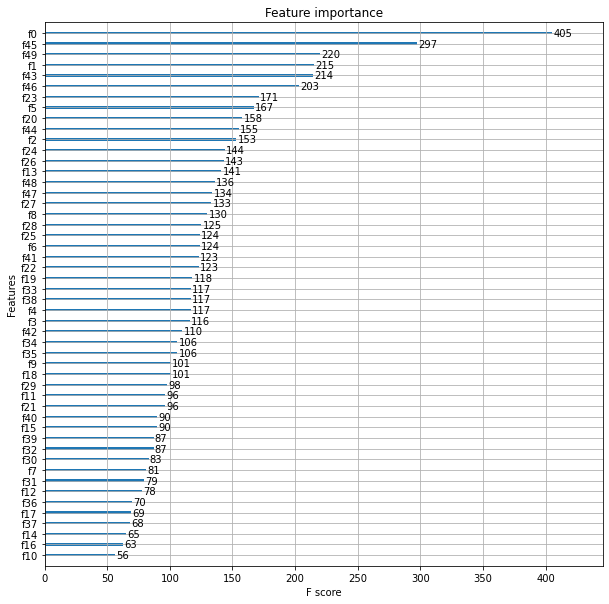

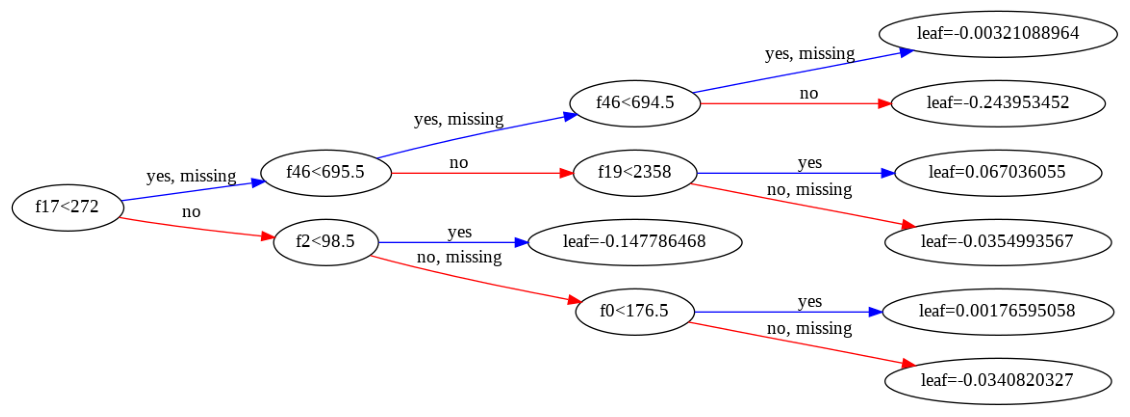

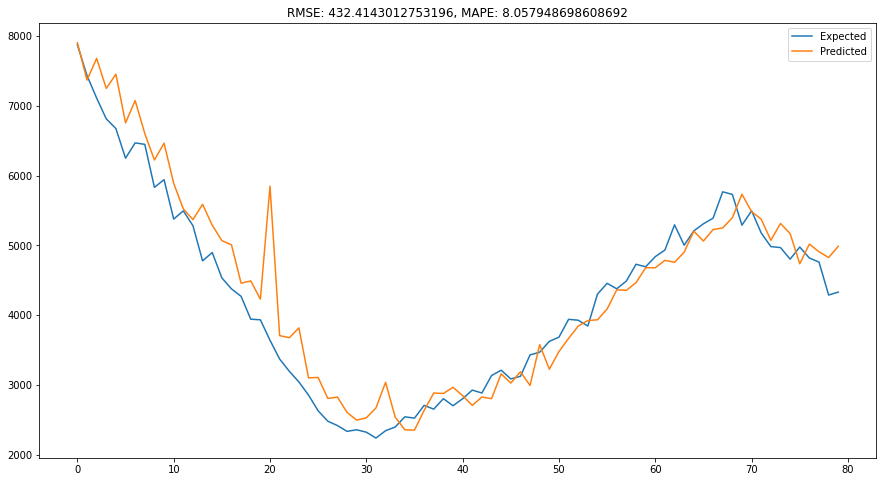

In [ ]:
# evaluate on
y_pred = 'CFuture4'
Xtrain_data = series_to_supervised(X_train_add, n_in=20)
Xtest_data = series_to_supervised(X_test_covid, n_in=20)
#future3:
params={'eta=': 0.2, 'max_depth':3, 'gamma': 0.3} # best params for core features & CFuture2
rmse, mape, y, yhat, model = walk_forward_validation(Xtrain_data, y_train_add[y_pred], Xtest_data, y_test_covid[y_pred],params)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
print(['Used params: ', params])

fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax=ax)
fig.savefig('CFuture4_core_best_FeatureRanking_covid_data.pdf')
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(model, ax=ax,rankdir="LR",num_trees=999)
fig.savefig('CFuture4_core_best_Tree_covid_data.pdf')
fig = plt.figure(figsize=(15,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.title(f'RMSE: {rmse}, MAPE: {mape}')
fig.savefig('CFuture4_core_COVIDreduced_wfv20_eta0-2_maxdepth3_gamma0-3.pdf')

In [12]:
# Test on Covid19 data - all features
# concat train + test data
X_train_all = pd.read_csv('train_X_all.csv'); X_test_all = pd.read_csv('test_X_all.csv')
y_train_all = pd.read_csv('train_y_all.csv'); y_test_all = pd.read_csv('test_y_all.csv')
X_train_add = pd.concat([X_train_all, X_test_all])
y_train_add = pd.concat([y_train_all, y_test_all])
# find covid data
df = pd.read_excel('ModelData_Cleaned.xlsx');
data_covid = df[df['Date'] > '2020-02-01']
data_covid = data_covid.drop(labels=["Date",'CWeekDay','CCoronaRelDateNum','CCoronaRelWeekNum','CWeekNumYear'],axis=1)
data_covid.head()
X_test_covid = data_covid.drop(labels=["CFuture1","CFuture2","CFuture3","CFuture4"],axis=1)
y_test_covid = data_covid[["CFuture1","CFuture2","CFuture3","CFuture4"]]

Xtrain_data = series_to_supervised(X_train_add, n_in=6)
Xtest_data = series_to_supervised(X_test_covid, n_in=6)
# evaluate on
y_pred = 'CFuture1'
#future1:
params={'eta=': 0.2, 'max_depth':5, 'gamma': 0.1} # best params for core features & CFuture1
rmse, mape, y, yhat, model = walk_forward_validation(Xtrain_data, y_train_add[y_pred], Xtest_data, y_test_covid[y_pred],params)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
print(['Used params: ', params])

fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax=ax)
#fig.savefig('CFuture1_core_best_FeatureRanking_covid_data.pdf')
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(model, ax=ax,rankdir="LR",num_trees=999)
#fig.savefig('CFuture1_core_best_Tree_covid_data.pdf')
fig = plt.figure(figsize=(15,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.title(f'RMSE: {rmse}, MAPE: {mape}')
fig.savefig('CFuture1_all_COVID_wfv6_eta0-2_maxdepth5_gamma0-1.pdf')

ValueError: ignored

In [ ]:
Xtrain_data = series_to_supervised(X_train_add, n_in=6)
Xtest_data = series_to_supervised(X_test_covid, n_in=6)
# evaluate on
y_pred = 'CFuture2'
params={'eta=': 0.3, 'max_depth':5, 'gamma': 0.2} # best params for core features & CFuture2
rmse, mape, y, yhat, model = walk_forward_validation(Xtrain_data, y_train_add[y_pred], Xtest_data, y_test_covid[y_pred],params)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
print(['Used params: ', params])

fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax=ax)
#fig.savefig('CFuture1_core_best_FeatureRanking_covid_data.pdf')
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(model, ax=ax,rankdir="LR",num_trees=999)
#fig.savefig('CFuture1_core_best_Tree_covid_data.pdf')
fig = plt.figure(figsize=(15,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.title(f'RMSE: {rmse}, MAPE: {mape}')
fig.savefig('CFuture2_all_COVID_wfv6_eta0-3_maxdepth5_gamma0-2.pdf')

In [ ]:
Xtrain_data = series_to_supervised(X_train_add, n_in=6)
Xtest_data = series_to_supervised(X_test_covid, n_in=6)
# evaluate on
y_pred = 'CFuture3'
params={'eta=': 0.1, 'max_depth':5, 'gamma': 0.4} # best params for core features & CFuture3
rmse, mape, y, yhat, model = walk_forward_validation(Xtrain_data, y_train_add[y_pred], Xtest_data, y_test_covid[y_pred],params)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
print(['Used params: ', params])

fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax=ax)
#fig.savefig('CFuture1_core_best_FeatureRanking_covid_data.pdf')
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(model, ax=ax,rankdir="LR",num_trees=999)
#fig.savefig('CFuture1_core_best_Tree_covid_data.pdf')
fig = plt.figure(figsize=(15,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.title(f'RMSE: {rmse}, MAPE: {mape}')
fig.savefig('CFuture3_all_COVID_wfv6_eta0-1_maxdepth5_gamma0-4.pdf')

In [ ]:
Xtrain_data = series_to_supervised(X_train_add, n_in=6)
Xtest_data = series_to_supervised(X_test_covid, n_in=6)
# evaluate on
y_pred = 'CFuture4'
eta=', 0.2, '; max_depth=', 3, '; gamma=', 0.4
params={'eta=': 0.2, 'max_depth':5, 'gamma': 0.1} # best params for core features & CFuture4
rmse, mape, y, yhat, model = walk_forward_validation(Xtrain_data, y_train_add[y_pred], Xtest_data, y_test_covid[y_pred],params)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
print(['Used params: ', params])

fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax=ax)
#fig.savefig('CFuture1_core_best_FeatureRanking_covid_data.pdf')
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(model, ax=ax,rankdir="LR",num_trees=999)
#fig.savefig('CFuture1_core_best_Tree_covid_data.pdf')
fig = plt.figure(figsize=(15,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.title(f'RMSE: {rmse}, MAPE: {mape}')
fig.savefig('CFuture4_all_COVID_wfv6_eta0-2_maxdepth3_gamma0-4.pdf')

# Model 2: predict the 'deviation' from planned exams (CFuture1 - NumSF1)

In [ ]:
# import the data (all features)
#X_train = pd.read_csv('train_X_all.csv'); X_test = pd.read_csv('test_X_all.csv')
#y_train = pd.read_csv('train_y_all.csv'); y_test = pd.read_csv('test_y_all.csv')
X_train = pd.read_csv('train_X.csv'); X_test = pd.read_csv('test_X.csv')
y_train = pd.read_csv('train_y.csv'); y_test = pd.read_csv('test_y.csv')
print(['Size train set: ',len(X_train)]);
print(['Size test set: ',len(X_test)]);
y_train['Deviation1'] = y_train['CFuture1'] - X_train['NumSF1']; y_test['Deviation1'] = y_test['CFuture1'] - X_test['NumSF1']
#X_train = X_train.drop(['YearDayNum','NumSF1','NumSF2','NumSF3','NumSF4'],axis=1);
#X_test = X_test.drop(['YearDayNum','NumSF1','NumSF2','NumSF3','NumSF4'],axis=1);

['Size train set: ', 294]
['Size test set: ', 56]


In [ ]:
# More features
X_train2 = X_train **2; X_test2 = X_test **2 # all features to the power of 2
X_train3 = X_train **3; X_test3 = X_test **3 # all features to the power of 3
X_traind =  pd.DataFrame(np.vstack((np.zeros((1,np.size(X_train,1))), np.diff(X_train, axis=0))),columns=X_train.keys()); # all features delta
X_testd =  pd.DataFrame(np.vstack((np.zeros((1,np.size(X_test,1))), np.diff(X_test, axis=0))),columns=X_test.keys()) # all features delta
X_trainr = round(np.sqrt(X_train),2); X_testr = round(np.sqrt(X_test),2) # all features to the root
X_traind.head(3)

YearDayNum  NumO1  NumO2  NumO3  ...  NumSF1  NumSF2  NumSF3  NumSF4
0         0.0    0.0    0.0    0.0  ...     0.0     0.0     0.0     0.0
1         1.0   -9.0    7.0    9.0  ...    -5.0    65.0     6.0    86.0
2         1.0    4.0   15.0   -2.0  ...    52.0   -35.0    75.0   -46.0

[3 rows x 25 columns]

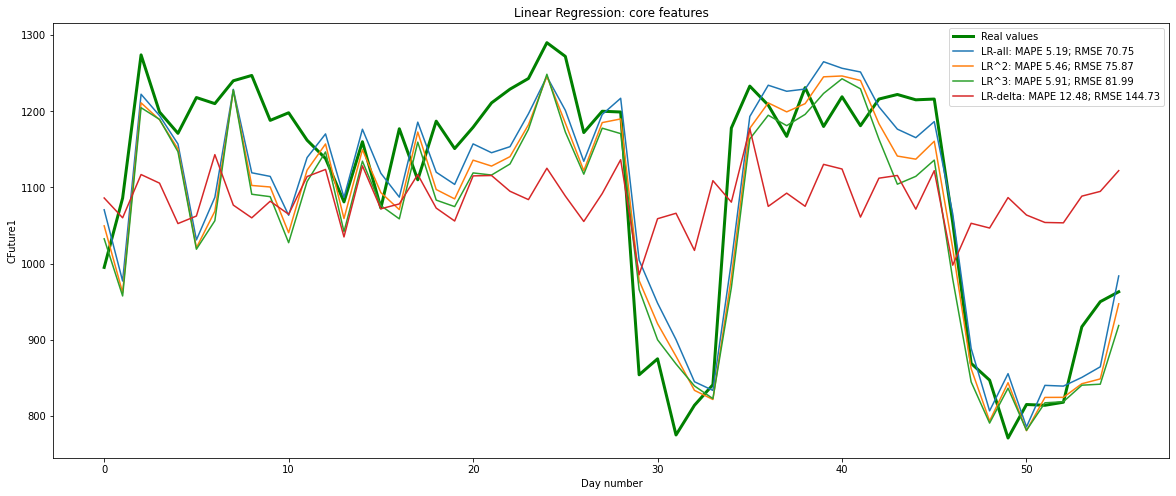

In [ ]:
# LR
from sklearn.linear_model import LinearRegression
from sklearn import metrics
Xtrain = [X_train, X_train2, X_train3, X_traind]; Xtest = [X_test, X_test2, X_test3, X_testd] #, X_testr]; , X_trainr - sqrt gives an error ^_-
fig, ax = plt.subplots(1,figsize=(20,8)); labels = ['LR-all', 'LR^2','LR^3','LR-delta','LR-sqrt']; ax.plot(y_test.CFuture1,color='green', label='Real values',linewidth=3)
for i in np.arange(len(Xtrain)):
  #tr = pd.concat([X_train,Xtrain[i]], axis=1); te = pd.concat([X_test,Xtest[i]], axis=1);
  tr = Xtrain[i]; te = Xtest[i]
  Xtr = tr.values.reshape(-1,np.size(tr,1)); Ytr = y_train.CFuture1.values.reshape(-1,1)
  Xte = te.values.reshape(-1, np.size(te,1)); Yte = y_test.CFuture1.values.reshape(-1,1)
  lr = LinearRegression()  # create LR
  lr.fit(Xtr,Ytr)  # fit the model
  Y_pred = lr.predict(Xte)  # predict
  mape = np.mean(np.abs((Yte - Y_pred) / Yte) * 100)
  rmse =np.sqrt(mean_squared_error(Yte,Y_pred))
#coeff1 = np.array2string(round(linear_regressor1.coef_[0][0], 4))
#intercept1 = np.array2string(round(linear_regressor1.intercept_[0], 2))
  ax.plot(Y_pred,label=labels[i]+': MAPE ' + str(round(mape,2)) + '; RMSE ' + str(round(rmse,2)))
  ax.legend()
  plt.title("Linear Regression: core features")
  if i ==2:
    model=lr # save best model (features ^3)
plt.ylabel('CFuture1'); plt.xlabel('Day number')
fig.savefig('CFuture1_core_LR.jpg')

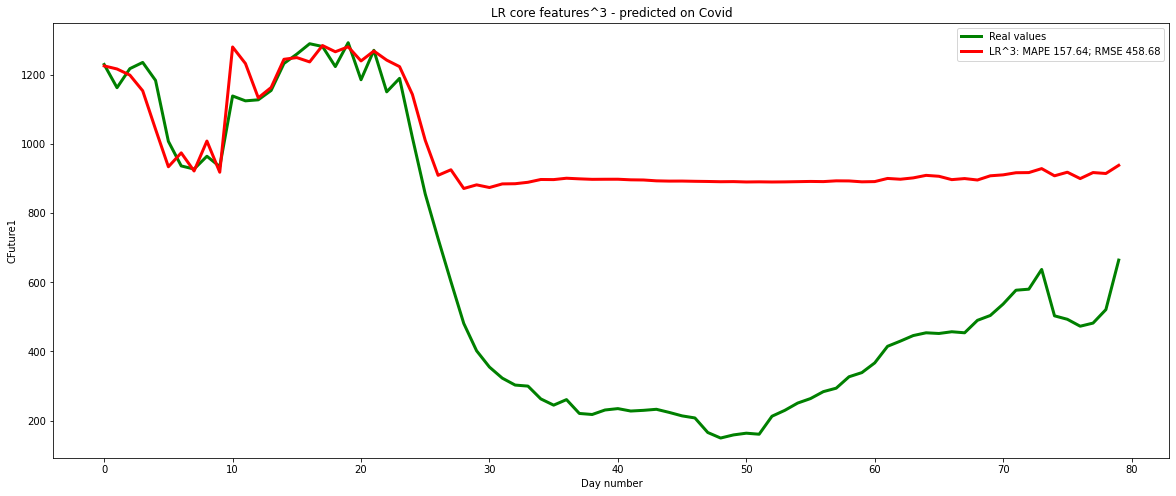

In [ ]:
# test best LR model on Covid data
X_train_add = pd.concat([X_train, X_test])
y_train_add = pd.concat([y_train, y_test])
# find covid data
df = pd.read_excel('ModelData_Cleaned.xlsx');
data_covid = df[df['Date'] > '2020-02-01'][0:80] # cut off the data points > 80 or after 26-520 (as they're inaccurate)
data_covid = data_covid.drop(labels=["Date",'CWeekDay','CCoronaRelDateNum','CCoronaRelWeekNum','CWeekNumYear'],axis=1)
data_covid.head()
X_test_covid = data_covid.drop(labels=["CFuture1","CFuture2","CFuture3","CFuture4"],axis=1) **3
y_test_covid = data_covid[["CFuture1","CFuture2","CFuture3","CFuture4"]]
y_pred_covid = model.predict(X_test_covid)
fig, ax = plt.subplots(1,figsize=(20,8));
ax.plot(y_test_covid.CFuture1.values,color='green', label='Real values',linewidth=3)
ax.plot(y_pred_covid,color='red', label='LR^3: MAPE ' + str(round(mape,2)) + '; RMSE ' + str(round(rmse,2)),linewidth=3)
y_real = y_test_covid.CFuture1.values
mape = np.mean(np.abs((y_real - y_pred_covid) / y_real) * 100)
rmse =np.sqrt(mean_squared_error(y_pred_covid,y_real))
plt.title('LR core features^3 - predicted on Covid')
plt.ylabel('CFuture1'); plt.xlabel('Day number')
plt.legend()
fig.savefig('CFuture1_core_LR3_covid.jpg')

In [ ]:
# Random augmented features - code adapted from Konstantin :)
import keras
df_train_X_augmented = pd.read_excel('train_X_augmented.xlsx')
df_test_X_augmented = pd.read_excel('test_X_augmented.xlsx')

# drop first row for augmented dataset (NaN due to delta feature)
df_test_X_augmented = df_test_X_augmented.iloc[1:]
df_train_X_augmented = df_train_X_augmented.iloc[1:]
df_test_y = df_test_y.iloc[1:]
df_train_y = df_train_y.iloc[1:]

np_train_X_augmented = df_train_X_augmented.to_numpy()
np_train_y = df_train_y.to_numpy()
np_test_X_augmented = df_test_X_augmented.to_numpy()
np_test_y = df_test_y.to_numpy()

best_rmse = 1000
mse = keras.losses.MeanSquaredError()
i = 1
while best_rmse > 50:
  bCols = np.random.choice([True, False], size=df_train_X_augmented.shape[1], p=[0.5,0.5])
  X = df_train_X_augmented.loc[:, bCols].to_numpy()
  y = np_train_y[:, 0]
  reg = LinearRegression().fit(X, y)
  predicted = np.zeros(df_test_X_augmented.shape[0])
  for i in range(df_test_X_augmented.shape[0]-1):
    predicted[i] = reg.predict(df_test_X_augmented.loc[i+1, bCols].to_numpy().reshape(1,X.shape[1]))
  rmse = np.round(np.sqrt(mse(predicted[:-1], np_test_y[:-1, 0]).numpy()), decimals = 2)
  i = i + 1
  if rmse < best_rmse:
    best_rmse = rmse
    best_boolean_mask = bCols

In [ ]:
X = df_train_X_augmented.loc[:, best_boolean_mask].to_numpy()
y = np_train_y[:, 0]
reg = LinearRegression().fit(X, y)
predicted = np.zeros(df_test_X_augmented.shape[0])
for i in range(df_test_X_augmented.shape[0]-1):
    predicted[i] = reg.predict(df_test_X_augmented.loc[i+1, best_boolean_mask].to_numpy().reshape(1,X.shape[1]))

In [ ]:
f, ax = plt.subplots(figsize=(15,6))

ax.plot(np_test_X[1:, 0] ,np_test_y[:, 0], 'x-', color='blue', label='real values')
ax.plot(np_test_X[1:, 0] ,predicted[:], color='black', label='predicted values')

ax.legend(loc='upper left')
ax.set_xlabel('YearDayNum')
ax.set_ylabel('CFuture1')
plt.show()
mape = np.round(100 * np.mean(np.mean(abs((predicted[:-1] - np_test_y[:-1, 0]) / np_test_y[:-1, 0]), axis=-1)), decimals=2)
mse = keras.losses.MeanSquaredError()
rmse = np.round(np.sqrt(mse(predicted[:-1], np_test_y[:-1, 0]).numpy()), decimals = 2)
print('Mape:', mape, ' RMSE:', rmse)

In [ ]:
df_train_X_augmented.loc[:, best_boolean_mask]

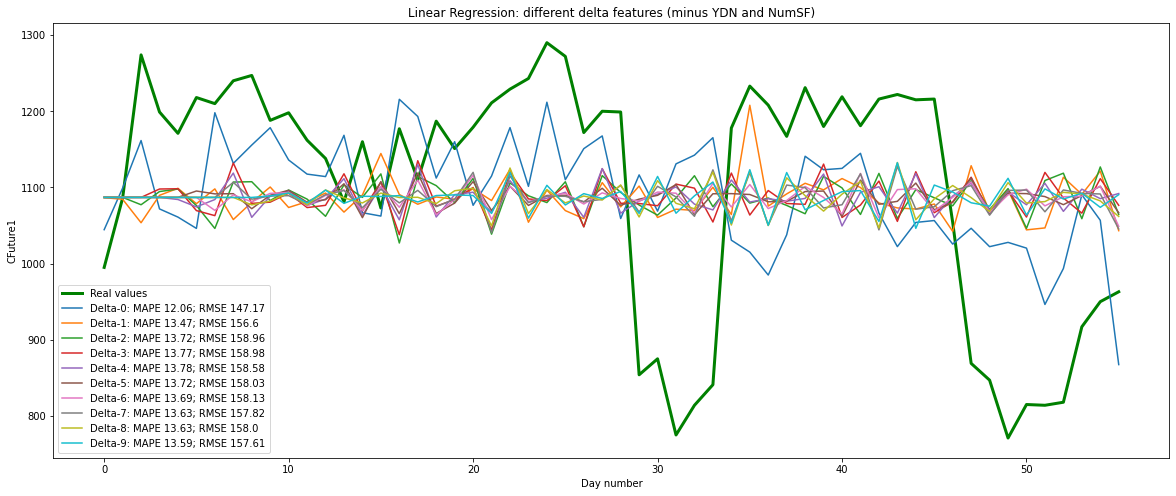

In [ ]:
fig, ax = plt.subplots(1,figsize=(20,8)); labels = ['LR-all', 'LR^2','LR^3','LR-delta','LR-sqrt'];
ax.plot(y_test.CFuture1,color='green', label='Real values',linewidth=3)

for i in np.arange(10):
  X_traind =  pd.DataFrame(np.vstack((np.zeros((i,np.size(X_train,1))), np.diff(X_train, axis=0, n=i))),columns=X_train.keys()); # all features delta
  X_testd =  pd.DataFrame(np.vstack((np.zeros((i,np.size(X_test,1))), np.diff(X_test, axis=0, n=i))),columns=X_test.keys())

  Xtr = X_traind.values.reshape(-1,np.size(X_traind,1)); Ytr = y_train.CFuture1.values.reshape(-1,1)
  Xte = X_testd.values.reshape(-1, np.size(X_testd,1)); Yte = y_test.CFuture1.values.reshape(-1,1)
  lr = LinearRegression()  # create LR
  lr.fit(Xtr,Ytr)  # fit the model
  Y_pred = lr.predict(Xte)  # predict
  mape = np.mean(np.abs((Yte - Y_pred) / Yte) * 100)
  rmse =np.sqrt(mean_squared_error(Yte,Y_pred))
#coeff1 = np.array2string(round(linear_regressor1.coef_[0][0], 4))
#intercept1 = np.array2string(round(linear_regressor1.intercept_[0], 2))
  ax.plot(Y_pred,label='Delta-' + str(i) +': MAPE ' + str(round(mape,2)) + '; RMSE ' + str(round(rmse,2)))
  ax.legend()
  plt.title("Linear Regression: different delta features (minus YDN and NumSF)")
plt.ylabel('CFuture1'); plt.xlabel('Day number')
fig.savefig('CFuture1_10deltafeautures_allminus_LR.jpg')

In [ ]:
# Same but XGBoost
# Param optimization
y_interest = 'CFuture1'
dtrain = xgb.DMatrix(df_train_X_augmented, label=df_train_y[y_interest]) # train data + y
dtest = xgb.DMatrix(df_test_X_augmented, label=df_test_y[y_interest]) # test data + y
# Params to loop over
eta= [0.001,0.01,0.1,0.2,0.3];
colsample_bytree= [0, 0.1, 0.2, 0.3, 0.5,0.7,0.9,1];
n_estimators= [10,20,50,60,80,90,100,120,130];
max_depth= [2,3,4,5];
min_samples_leaf= [10,20,40,80];
gamma=[0.1,0.2,0.3,0.4,0.5];

# Train
for ieta in eta:
  for idepth in max_depth:
    for igamma in gamma:
      params={
          'objective':'reg:squarederror','eval_metric':'rmse',
          'eta':ieta, 'max_depth':idepth, 'gamma':igamma
      }
      bst = xgb.train(params, dtrain,num_boost_round=100); #number of rounds -> the higher, the higher the 'feature importance'
      # Predict
      ypred = bst.predict(dtest)
      print(['\nWith eta=',ieta,'; max_depth=',idepth,'; gamma=',igamma,':'])
      print('\nRMSE" ', np.sqrt(mean_squared_error(df_test_y[y_interest],ypred)));#y_test[y_interest]
      print(xgb_mape(ypred,dtest))
# Optimized:
# X_train - eta=', 0.1, '; max_depth=', 2, '; gamma=', 0.4
# X_train2 - eta=', 0.1, '; max_depth=', 2, '; gamma=', 0.4
# X_train3 - eta=', 0.3, '; max_depth=', 5, '; gamma=', 0.4
# X_traind - eta=', 0.2, '; max_depth=', 3, '; gamma=', 0.4
# X_trainr - eta= 0.2, '; max_depth=', 3, '; gamma=', 0.4
# augmented cores features (Konstantin): RMSE"  87.36186672948749; ('MAPE (%)', 6.7437925)
#['\nWith eta=', 0.2, '; max_depth=', 3, '; gamma=', 0.4, ':']

['\nWith eta=', 0.001, '; max_depth=', 2, '; gamma=', 0.1, ':']

RMSE"  1008.9274184048268
('MAPE (%)', 90.31643)
['\nWith eta=', 0.001, '; max_depth=', 2, '; gamma=', 0.2, ':']

RMSE"  1008.9274184048268
('MAPE (%)', 90.31643)
['\nWith eta=', 0.001, '; max_depth=', 2, '; gamma=', 0.3, ':']

RMSE"  1008.9274184048268
('MAPE (%)', 90.31643)
['\nWith eta=', 0.001, '; max_depth=', 2, '; gamma=', 0.4, ':']

RMSE"  1008.9274184048268
('MAPE (%)', 90.31643)
['\nWith eta=', 0.001, '; max_depth=', 2, '; gamma=', 0.5, ':']

RMSE"  1008.9274184048268
('MAPE (%)', 90.31643)
['\nWith eta=', 0.001, '; max_depth=', 3, '; gamma=', 0.1, ':']

RMSE"  1008.9274184048268
('MAPE (%)', 90.31643)
['\nWith eta=', 0.001, '; max_depth=', 3, '; gamma=', 0.2, ':']

RMSE"  1008.9274184048268
('MAPE (%)', 90.31643)
['\nWith eta=', 0.001, '; max_depth=', 3, '; gamma=', 0.3, ':']

RMSE"  1008.9274184048268
('MAPE (%)', 90.31643)
['\nWith eta=', 0.001, '; max_depth=', 3, '; gamma=', 0.4, ':']

RMSE"  1008.92741840482

In [ ]:
params_all = [{'eta=': 0.1, 'max_depth':2, 'gamma': 0.4},{'eta=': 0.1, 'max_depth':2, 'gamma': 0.4},{'eta=': 0.3, 'max_depth':5, 'gamma': 0.4},
              {'eta=': 0.2, 'max_depth':3, 'gamma': 0.4},{'eta=': 0.2, 'max_depth':3, 'gamma': 0.4}]
Xtrain = [X_train, X_train2, X_train3, X_traind, X_trainr]; Xtest = [X_test, X_test2, X_test3, X_testd, X_testr];
y_interest = 'Deviation1'

fig, ax = plt.subplots(1,figsize=(20,8)); labels = ['LR-all', 'LR^2','LR^3','LR-delta','LR-sqrt']; ax.plot(y_test.Deviation1,color='green', label='Real values',linewidth=3)
for i in np.arange(len(Xtrain)):
  Xtrain_data = series_to_supervised(Xtrain[i], n_in=6);
  Xtest_data = series_to_supervised(Xtest[i], n_in=6);
  params=params_all[i]
  rmse, mape, y, yhat, model = walk_forward_validation(Xtrain_data, y_train[y_interest], Xtest_data, y_test[y_interest],params)
  ax.plot(yhat,label=labels[i]+': MAPE ' + str(round(mape,2)) + '; RMSE ' + str(round(rmse,2)))
  ax.legend()
  plt.title('XGBoost')
plt.ylabel('Deviation1 (CF1-NSF1)'); plt.xlabel('Day number')
fig.savefig('Deviation1_all_XGB.jpg')
#Xtrain_data2 = series_to_supervised(X_train2, n_in=6); Xtest_data2 = series_to_supervised(X_test2, n_in=6);params2={'eta=': 0.1, 'max_depth':2, 'gamma': 0.4}
#Xtrain_data3 = series_to_supervised(X_train3, n_in=6); Xtest_data3 = series_to_supervised(X_test, n_in=6);params1={'eta=': 0.1, 'max_depth':2, 'gamma': 0.4}
#Xtrain_data1 = series_to_supervised(X_train, n_in=6); Xtest_data1 = series_to_supervised(X_test, n_in=6);params1={'eta=': 0.1, 'max_depth':2, 'gamma': 0.4}
#Xtrain_data1 = series_to_supervised(X_train, n_in=6); Xtest_data1 = series_to_supervised(X_test, n_in=6);params1={'eta=': 0.1, 'max_depth':2, 'gamma': 0.4}

In [ ]:
df_test_X_augmented_covid #87 x 97
df_train_X_augmented.iloc[:,1:] #293 x 98
#df_train_y #293
#df_test_X_augmented_covid
#df_test_y_covid #174

YearDayNum  NumO1  NumO2  NumO3  ...  sqNumSF1  sqNumSF2  sqNumSF3  sqNumSF4
1           283     55     77    104  ...    234256    906304   1999396   4635409
2           284     59     92    102  ...    287296    840889   2217121   4439449
3           285     49     79     92  ...    303601   1004004   2477476   4963984
4           288     44     75     94  ...    341056    902500   2588881   4656964
5           289     46     73     96  ...    302500    990025   2666689   5555449
..          ...    ...    ...    ...  ...       ...       ...       ...       ...
289          55     33     67     80  ...    524176   1454436   2762244   3455881
290          56     58    103    136  ...    552049   1505529   2869636   3076516
291          57     52    102    124  ...    531441   1790244   2696164   3250809
292          58     51     91    107  ...    534361   1607824   2146225   2768896
293          59     48     94    120  ...    544644   1666681   2047761   2368521

[293 rows x 97 columns]

>expected=1086.0, predicted=960.9
>expected=1274.0, predicted=1133.3
>expected=1199.0, predicted=1171.4
>expected=1171.0, predicted=1183.9
>expected=1218.0, predicted=1085.0
>expected=1210.0, predicted=1183.1
>expected=1240.0, predicted=1173.5
>expected=1247.0, predicted=1205.4
>expected=1188.0, predicted=1162.3
>expected=1198.0, predicted=1138.6
>expected=1162.0, predicted=1192.9
>expected=1138.0, predicted=1165.0
>expected=1081.0, predicted=1185.4
>expected=1160.0, predicted=1174.9
>expected=1073.0, predicted=1115.4
>expected=1177.0, predicted=1141.3
>expected=1110.0, predicted=1181.3
>expected=1187.0, predicted=1190.6
>expected=1151.0, predicted=1147.9
>expected=1179.0, predicted=1187.7
>expected=1211.0, predicted=1151.2
>expected=1229.0, predicted=1176.1
>expected=1243.0, predicted=1169.0
>expected=1290.0, predicted=1206.7
>expected=1272.0, predicted=1215.5
>expected=1172.0, predicted=1218.1
>expected=1200.0, predicted=1212.2
>expected=1199.0, predicted=1213.7
>expected=854.0, pred

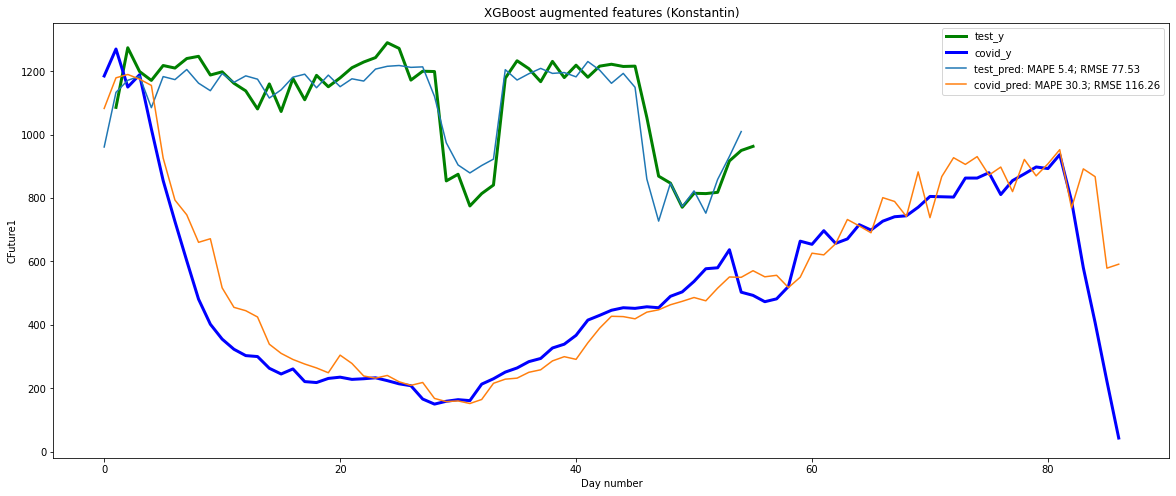

In [ ]:
# XGBoost withdf_train_X_augmented = pd.read_excel('train_X_augmented.xlsx')
df_test_X_augmented = pd.read_excel('test_X_augmented.xlsx')
df_train_X_augmented = pd.read_excel('train_X_augmented.xlsx')
df_test_X_augmented_covid = pd.read_excel('test_X_augmented_covid.xlsx')
train_y = pd.read_csv('train_y.csv'); test_y = pd.read_csv('test_y.csv')
# load covid y
df = pd.read_excel('ModelData_Cleaned.xlsx');

#data_covid = df[(df['YearDayNum'] > 61) & (df['YearDayNum'] < 185)] #[0:80] # cut off the data points > 80 or after 26-520 (as they're inaccurate)
data_covid = df[df['Date'] > '2020-03-01'][0:88]
data_covid = data_covid.drop(labels=["Date",'CWeekDay','CCoronaRelDateNum','CCoronaRelWeekNum','CWeekNumYear'],axis=1)
#X_test_covid = data_covid.drop(labels=["CFuture1","CFuture2","CFuture3","CFuture4"],axis=1)
y_test_covid = data_covid[["CFuture1","CFuture2","CFuture3","CFuture4"]]
# drop first row for augmented dataset (NaN due to delta feature)
df_test_X_augmented = df_test_X_augmented.iloc[1:]
df_train_X_augmented = df_train_X_augmented.iloc[1:]
df_test_X_augmented_covid = df_test_X_augmented_covid.iloc[1:]
df_test_y = test_y.iloc[1:,0]
df_train_y = train_y.iloc[1:,0]
df_test_y_covid = y_test_covid.iloc[1:,0]

#np_train_X_augmented = df_train_X_augmented.to_numpy()
#np_train_y = df_train_y.to_numpy()
#np_test_X_augmented = df_test_X_augmented.to_numpy()
#np_test_y = df_test_y.to_numpy()
#np_test_X_augmented_covid = df_test_X_augmented_covid.to_numpy()
#np_test_y_covid = df_test_y_covid.to_numpy()

# Optimmized params: eta=', 0.2, '; max_depth=', 3, '; gamma=', 0.4, ':']
params_all = {'eta=': 0.2, 'max_depth':3, 'gamma': 0.4}
Xtrain = [df_train_X_augmented, df_train_X_augmented.iloc[:,1:]]; Xtest = [df_test_X_augmented, df_test_X_augmented_covid];
Ytest = [df_test_y, df_test_y_covid]
y_interest = 'CFuture1'

fig, ax = plt.subplots(1,figsize=(20,8)); labels = ['test_y', 'covid_y','test_pred','covid_pred'];
ax.plot(df_test_y,color='green', label=labels[0],linewidth=3)
ax.plot(np.arange(len(df_test_y_covid)),df_test_y_covid,color='blue', label=labels[1],linewidth=3)
for i in np.arange(len(Xtrain)):
  Xtrain_data = series_to_supervised(Xtrain[i], n_in=6);
  Xtest_data = series_to_supervised(Xtest[i], n_in=6);
  y_test = Ytest[i]
  params=params_all
  rmse, mape, y, yhat, model = walk_forward_validation(Xtrain_data, df_train_y, Xtest_data, y_test,params)
  ax.plot(yhat,label=labels[i+2]+': MAPE ' + str(round(mape,2)) + '; RMSE ' + str(round(rmse,2)))
  ax.legend()
  plt.title('XGBoost augmented features (Konstantin)')
plt.ylabel('CFuture1'); plt.xlabel('Day number')
fig.savefig('CFuture1_core-aug_XGB.jpg')


# Scale features

In [ ]:
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Adapted from Johannes
# Scale features to improve model performance
# Define Scalers
stScaler = StandardScaler()
mmScaler = MinMaxScaler()

# Define which columns should be scaled
columns_to_scale  = ['at_inbound', 'at_outbound']
#columns_to_scale  = ['temp', 'wspd']

add_also = ['COND_Snow','WTYPE_Fog','WTYPE_Ice','WTYPE_Smoke_Or_Haze', 'temp', 'wspd']

# Scale and Encode Separate Columns
scaled_columns_train = stScaler.fit_transform(df_train_X_full[columns_to_scale])
scaled_columns_test = stScaler.fit_transform(df_test_X_full[columns_to_scale])

# Concatenate the scaled columns and subsets to numpy arrays for both train and test sets
np_train_X = np.concatenate(
    [df_train_X.loc[:,'NumO1':'WoM_Fourth'], scaled_columns_train, df_train_X_full[add_also]],
    axis=1
    )
np_train_y = df_train_y.to_numpy()
np_test_X = np.concatenate(
    [df_test_X.loc[:,'NumO1':'WoM_Fourth'], scaled_columns_test, df_test_X_full[add_also]],
    axis=1
    )
np_test_y = df_test_y.to_numpy()

# Keras autoparam tuner

In [4]:
import tensorflow as tf
from tensorflow import keras
!pip install -q -U keras-tuner
import kerastuner as kt
# kt: BayesianOptimization, Hyperband, RandomSearch or SKlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.8 MB/s eta 0:00:00


In [ ]:
def build_model(hp):
  model = xgb.XGBRegressor();
  return model

tuner = kt.Hyperband(build_model,objective='val_accuracy', max_epochs=10,factor=3)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

RuntimeError: ignored